#  SN Rate Metric


utilities needed the code: h5py, psnid (from SNANA package);

**Import lsst and utilities packages**

**template_lc** is a python class that allows to produce the template_lc.txt file (see below for the specifics) with the template lc in a redshift range that has to be specified by the user


In [1]:
import sys, os, h5py, pickle, warnings, subprocess
sys.path.append('/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs')
from opsimUtils import *
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from lsst.sims.maf.metrics import BaseMetric
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.utils import equatorialFromGalactic, galacticFromEquatorial
from lsst.sims.maf.utils import m52snr, radec2pix
from lsst.sims.utils import hpid2RaDec, angularSeparation
import pandas as pd
from pylab import cm
import time
from itertools import groupby
os.environ['SNANA_DIR']='/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs/SNRate_Simulations/SNANA'
os.environ['SNDATA_ROOT']='/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs/SNRate_Simulations/SNDATA_ROOT'
os.environ['LSST_DIR']='/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs/metrics_and_documentation/util_snrmetric'
%matplotlib inline

The following cell imports the opsims database names and create empty files to upload the results in.

In [6]:
your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.7/'
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRate_cadence_v1.7'.format(your_username)

if not os.path.exists(os.path.abspath(outDir)):
    os.mkdir(os.path.abspath(outDir))
    
dbRuns = show_opsims(dbDir)
# two dictionary are returned by the following function, 
# One (opSimDbs) is a dictionary storing all database objects
# Another (resultDbs) is a dictionary consist of the objects directing MAF where to save metric metadata
# Both dictionaries are indexed by OpSim run names
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)

################ MAF constrains to select the data and the positions in the Opsim ################

Here the RA and DEC of the observations are defined.

**slicermode**: indicate the type of slicer (the way you want to sort the data form the database)
 
        - SlicePoints: A spatial slicer that allows to select specifics pointings. A set of RA & DEC is passed to the API to extract approximated observational features in the injected positions.
         
        - HealpixSlicer: A spatial slicer that evaluates pointings on a healpix-based grid (the grid area divide the observed sky in nside x nside bins). The footprint is tasselated in a number of healpixels of equal area, which define the resolution of the observation.
        
        - Unislicer: This slicer simply returns the indexes of all data points. No slicing done at all.
   

In [3]:
surveyDuration = 1
init = 1 #aggiungere cosa significa init
sqlconstraint_DDF = '( filter= "g" or  filter = "r" or filter="i")'
sqlconstraint_DDF+='and night>{} and night < {} '.format(init*365.25,(init+surveyDuration)*365.25 )
sqlconstraint_DDF+=' and proposalId > 1'  #indica a cosa sono riferiti i differenti proposalId

In [5]:
class get_Col(BaseMetric):
    def __init__(self,  metricName='get_Col',Col=['expMJD',
                 'fiveSigmaDepth','filter', 'fieldRA', 'fieldDec', 
                 'seeingFwhmEff'], dataout=False, **kwargs):
        
        """
    Parameters:
    ___________
    Survey Parameters:
        Col = an array with the column names form the Opsim database
    __________
    
    OUTPUT:
        Dictionary with the column values
        
    """
        
        self.Col= Col
                
        # if you want to get the light curve in output you need to define the metricDtype as object
        super(get_Col, self).__init__(self.Col,metricDtype='object', units='',
                                                       metricName=metricName, **kwargs)
        
    def run(self, dataSlice, slicePoint=None):
        
        # Sort the entire dataSlice in order of time.
        dataSlice.sort(order='observationStartMJD')
        r = {c:dataSlice[c] for c in self.Col}
        r.update({'coo':(np.median(dataSlice['fieldRA']), np.median(dataSlice['fieldDec']))})
        return r
            

### Test 

In [7]:
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRate_cadence_v1.7'.format(your_username)
for n in [8,16,32,64]:
    for run in ['baseline_nexp1_v1.7_10yrs']:#dbRuns:
        nside = n
        slicer = slicers.HealpixSlicer(nside=nside)
        #slicer=slicers.UniSlicer()
        pixelarea = hp.nside2pixarea(nside,degrees=True)

        get_Colmetric = get_Col(metricName= 'getcol_{}'.format(n),Col=['observationStartMJD',
                         'fiveSigmaDepth','filter', 'fieldRA', 'fieldDec', 
                         'seeingFwhmEff','night','numExposures','visitTime','visitExposureTime'],
                                dataout=True)

        metriclc_get_Colmetric= metricBundles.MetricBundle(get_Colmetric, slicer, sqlconstraint_DDF)
        bundleDict={'COL':metriclc_get_Colmetric}


        warnings.filterwarnings('ignore')
        print('##############\n')
        print('{} is running\n'.format(run))
        print('##############\n')
        start_time = time.time()
        metriclc_get_Colmetric.setRunName(run)
        bgrouplc = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], metricDataPath, resultDbs[run])
        bgrouplc.runAll()
        print("--- {:.2f} minutes ---\n".format((float(time.time()) - float(start_time))/60))
        print('####################\n')

Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
##############

baseline_nexp1_v1.7_10yrs is running

##############

Querying database SummaryAllProps with constraint ( filter= "g" or  filter = "r" or filter="i")and night>365.25 and night < 730.5  and proposalId > 1 for columns ['observationStartMJD', 'visitExposureTime', 'night', 'numExposures', 'visitTime', 'fieldDec', 'seeingFwhmEff', 'fiveSigmaDepth', 'fieldRA', 'filter']
Found 5722 visits
Running:  ['COL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 0.05 minutes ---

####################

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
##############

baseline_nexp1_v1.7_10yrs is running

##############

Querying database SummaryAllProps with constraint ( filter= "g" or  filter = "r" or filter="i")and night>365.25 and night < 730.5  and proposalId > 1 for columns ['observationStartMJD', 'visitExposureTime', 'night', 'numExpo

ValueError: Valid values of nside are powers of 2.

The cells below allows to extract the results from the MAF and to save them in a dictionary

In [8]:
resultDbs = getResultsDbs(outDir)
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRate_cadence_v1.7'.format(your_username)
# the following line will be useful if you did not run MAF on all 75 opsims
runNames = list(resultDbs.keys())
bundleDicts = {}
for runName in ['baseline_nexp1_v1.7_10yrs']:#,dbRuns[29]]:
       bundleDicts[runName] = bundleDictFromDisk(resultDbs[runName], runName, metricDataPath)

Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [9]:
bundleDicts['baseline_nexp1_v1.7_10yrs'].keys()

dict_keys([(1, 'getcol_8'), (2, 'getcol_16'), (3, 'getcol_32'), (4, 'getcol_64')])

In [10]:
df17={}
coo_df={}
for opsim in  ['baseline_nexp1_v1.7_10yrs']:#,'baseline_nexp2_v1.7_10yrs']:
    df17[opsim]={}
    coo_df[opsim]={}
    
    bmetric =[(1, 'getcol_8'), (2, 'getcol_16'), (3, 'getcol_32'), (4, 'getcol_64')]
    for metric in bmetric:#, (4, 'II'), (5, 'Ibc')]:
        coo_df[opsim][metric[1]] = np.column_stack((bundleDicts[opsim][metric].slicer.slicePoints['ra'][np.where(bundleDicts[opsim][metric].metricValues.mask==False)]
                                          ,bundleDicts[opsim][metric].slicer.slicePoints['dec'][np.where(bundleDicts[opsim][metric].metricValues.mask==False)]))
        arr=bundleDicts[opsim][metric].metricValues.data
        arr_=arr[np.where(arr!=None)]
        df17[opsim][metric[1]] = pd.DataFrame.from_records(arr_)

In [12]:
def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec

In [13]:
from pylab import cm
def plt_mlw(ax,ra,dec,org=0,projection='mollweide',c= 'null', vmin=0,vmax=1, dicts={}):
    args={'colormap': None,'marker':'o','linewidths':0,'title':'mlw_plot','xlabel':'x','ylabel':'y', 'fontsize':12,'cbartitle': 'score','psize':100}
    if dicts:
        args.update(dicts)
    if args['colormap']:
        cmap = cm.get_cmap(args['colormap'])
    else:
        cmap=None
        
    if c =='null':
        c= np.ones(len(ra))
    else:
        c=c
     
    x = np.remainder(ra+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    #ax = fig.add_subplot(111, projection=projection)
    ax.set_title(args['title'])
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis    
    ax.title.set_fontsize(12)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    im=plt.scatter(np.radians(x),np.radians(dec),c=c, s=args['psize'],cmap=cmap, marker = args['marker'], vmin = vmin, vmax = vmax, linewidths = args['linewidths'], zorder = 10)
    #ax.tick_params('both', labelsize=14)
    if cmap:
        cb=plt.colorbar(im,aspect=50,orientation='horizontal')
        cb.set_label(args['cbartitle'], size=12)
        for t in cb.ax.get_xticklabels():
             t.set_fontsize(12)

### Fraction of correctly classified SNe as function of number of visits

In [15]:
df17['baseline_nexp1_v1.7_10yrs'].keys()

dict_keys(['getcol_8', 'getcol_16', 'getcol_32', 'getcol_64'])

In [19]:
nvis={}
see={}
m5={}
filters={}
for k in df17['baseline_nexp1_v1.7_10yrs'].keys():
    nvis[k]=[]
    see[k]=[]
    m5[k]=[]
    filters[k]=[]
    for i in range(len(df17['baseline_nexp1_v1.7_10yrs'][k]['observationStartMJD'])):
        filters[k].append(np.size(np.unique(df17['baseline_nexp1_v1.7_10yrs'][k]['filter'][i])))
    for i in range(len(df17['baseline_nexp1_v1.7_10yrs'][k]['observationStartMJD'])):
        nvis[k].append(np.size(df17['baseline_nexp1_v1.7_10yrs'][k]['observationStartMJD'][i]))
    for i in range(len(df17['baseline_nexp1_v1.7_10yrs'][k]['observationStartMJD'])):
        see[k].append(np.median(df17['baseline_nexp1_v1.7_10yrs'][k]['seeingFwhmEff'][i]))
    for i in range(len(df17['baseline_nexp1_v1.7_10yrs'][k]['observationStartMJD'])):
        m5[k].append(np.median(df17['baseline_nexp1_v1.7_10yrs'][k]['fiveSigmaDepth'][i]))

In [43]:
nvis_filt = {'g':[],'r':[],'i':[]}
pairs={'id':[],'pairs':[]}
for i in range(len(df17['baseline_nexp1_v1.7_10yrs']['Ia_DDF_test']['class'])):    
    idx_g=np.where(df17['baseline_nexp1_v1.7_10yrs']['get_Col']['filter'][i]=='g')
    idx_r=np.where(df17['baseline_nexp1_v1.7_10yrs']['get_Col']['filter'][i]=='r')
    idx_i=np.where(df17['baseline_nexp1_v1.7_10yrs']['get_Col']['filter'][i]=='i')
    nvis_filt['g'].append(np.size(df17['baseline_nexp1_v1.7_10yrs']['get_Col']['observationStartMJD'][i][idx_g]))
    nvis_filt['r'].append(np.size(df17['baseline_nexp1_v1.7_10yrs']['get_Col']['observationStartMJD'][i][idx_r]))
    nvis_filt['i'].append(np.size(df17['baseline_nexp1_v1.7_10yrs']['get_Col']['observationStartMJD'][i][idx_i]))
    epoch_g = df17['baseline_nexp1_v1.7_10yrs']['get_Col']['observationStartMJD'][i][idx_g]
    epoch_r = df17['baseline_nexp1_v1.7_10yrs']['get_Col']['observationStartMJD'][i][idx_r]
    epoch_i = df17['baseline_nexp1_v1.7_10yrs']['get_Col']['observationStartMJD'][i][idx_i]
    gr=[]
    ri=[]
    for g in epoch_g:
        gr.append(np.absolute(g-epoch_r))
    if gr: gr=np.concatenate(gr)
    ri=[] 
    for r in epoch_r:
        ri.append(np.absolute(r-epoch_i))
    if ri:ri=np.concatenate(ri)
    epoch_pairs=np.concatenate([gr,ri])
    pairs['id'].append(np.ones(len(epoch_pairs),dtype=int)*int(i))
    pairs['pairs'].append(epoch_pairs)

____________________
NSIDE =8
____________________
[35.3271335166709, -4.956245128231688]


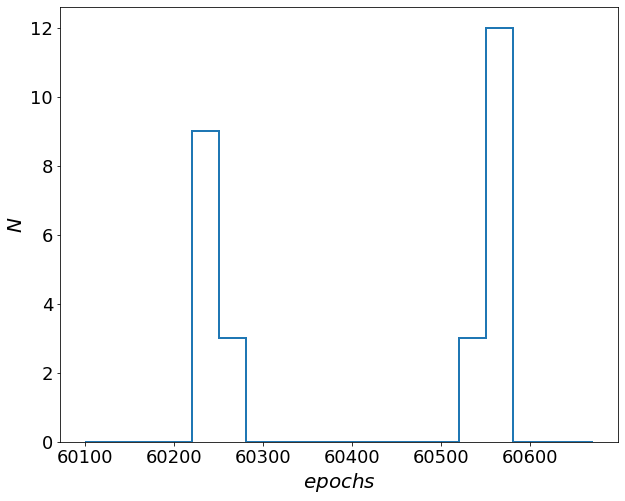

[59.256856762451385, -49.250049788814636]


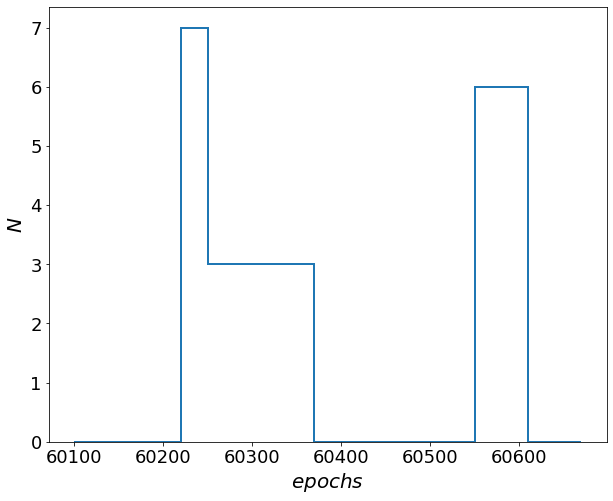

____________________
NSIDE =16
____________________
[150.3537683359455, 1.9314822096313506]


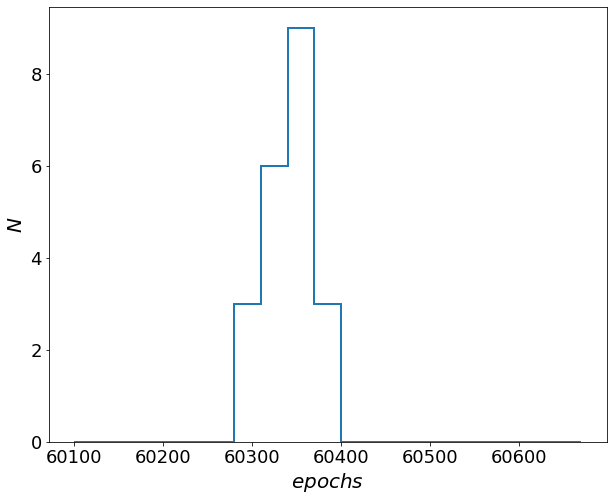

[35.67587285492021, -4.8825792814816005]


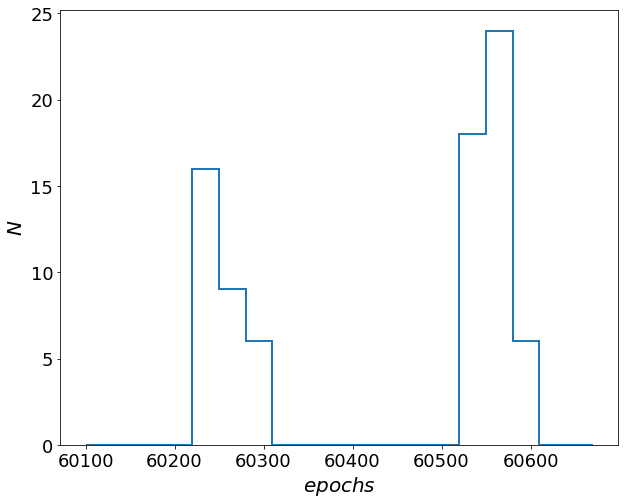

[53.16362465874926, -28.585053452183445]


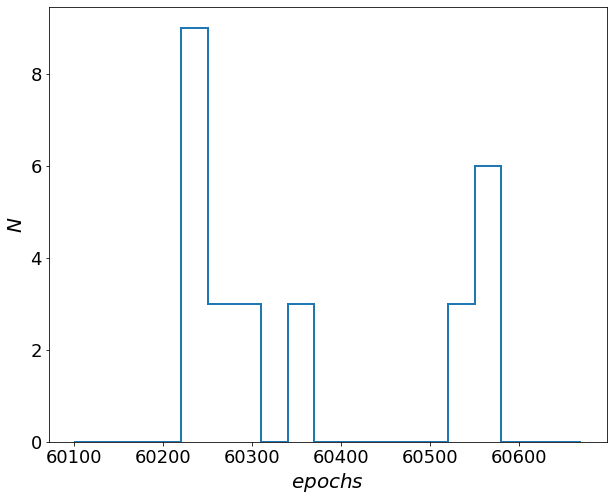

[9.576144658002292, -44.05510492684386]


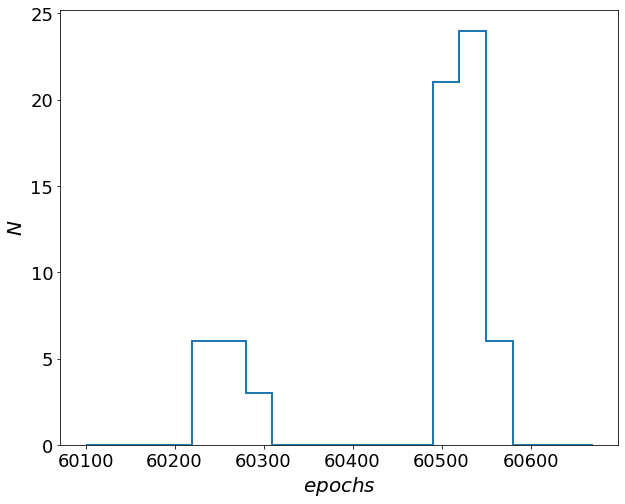

[62.61393643741137, -47.87813591201305]


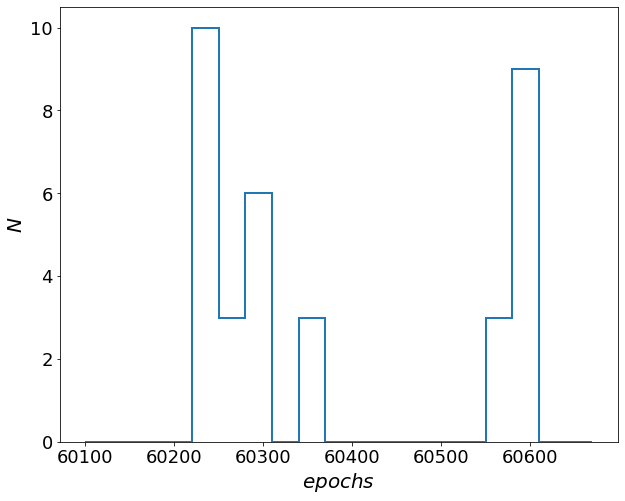

____________________
NSIDE =32
____________________
[149.82812181301662, 2.3602693769897627]


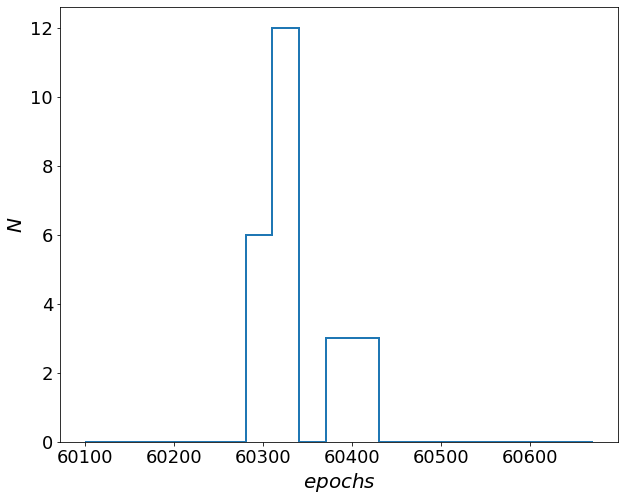

[150.62616922348633, 2.6425036390647865]


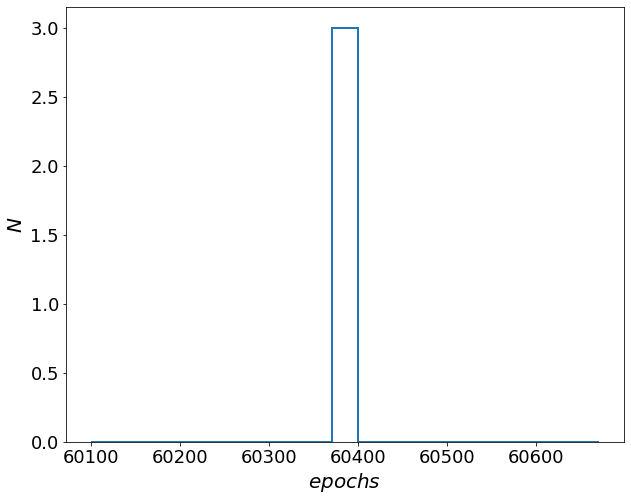

[150.0845005799753, 2.0592021423250273]


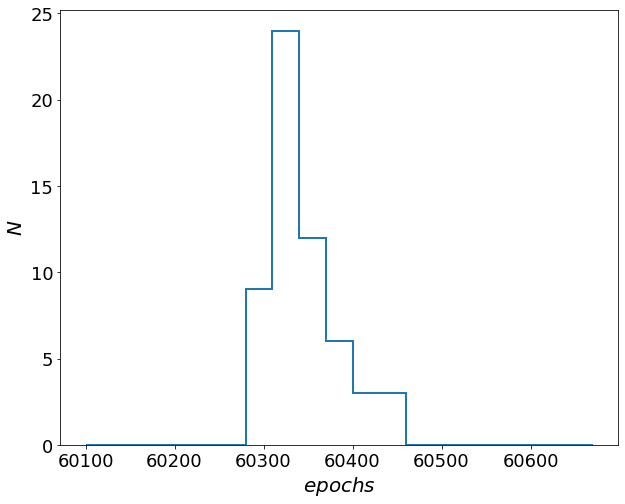

[149.9918047107118, 1.9647874790730027]


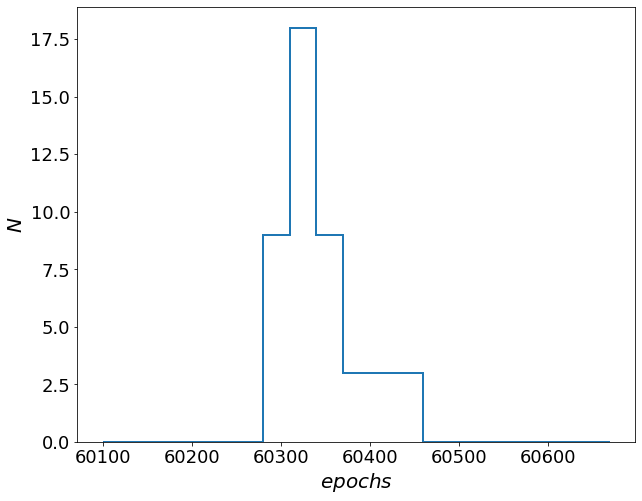

[150.3537683359455, 1.8412100177401596]


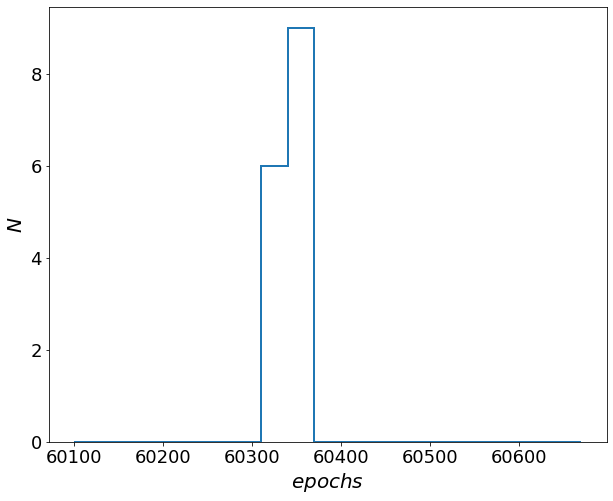

[150.19981754631073, 1.5947670521750508]


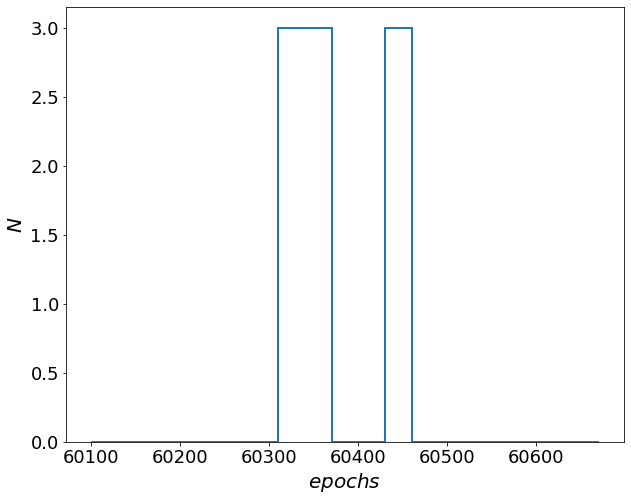

[35.22664455709531, -4.326599791589057]


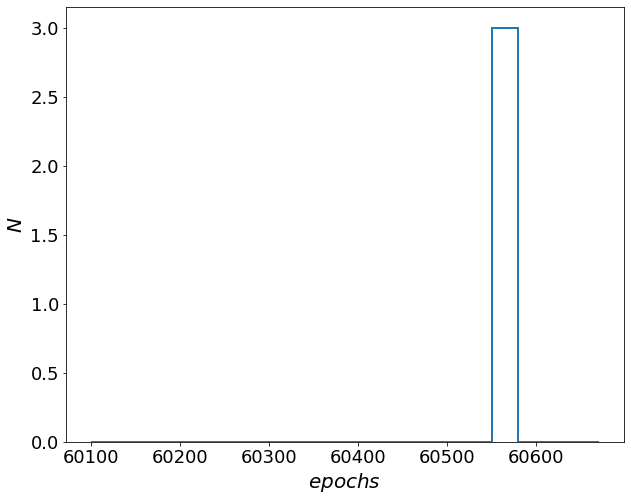

[35.75093446983255, -4.737796598373988]


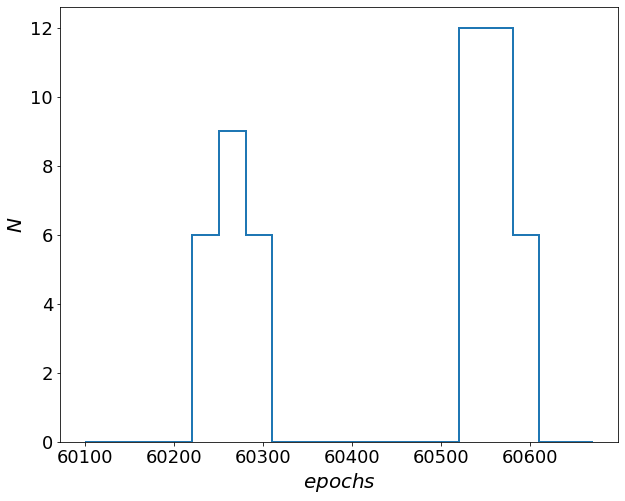

[35.67587285492021, -4.8825792814816005]


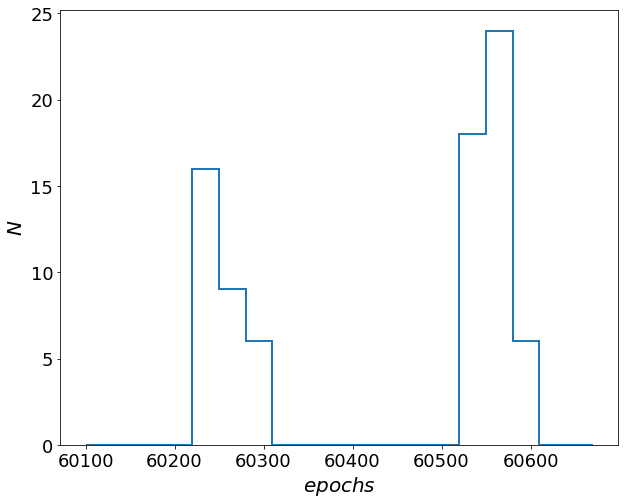

[36.276739581361284, -4.737796598373988]


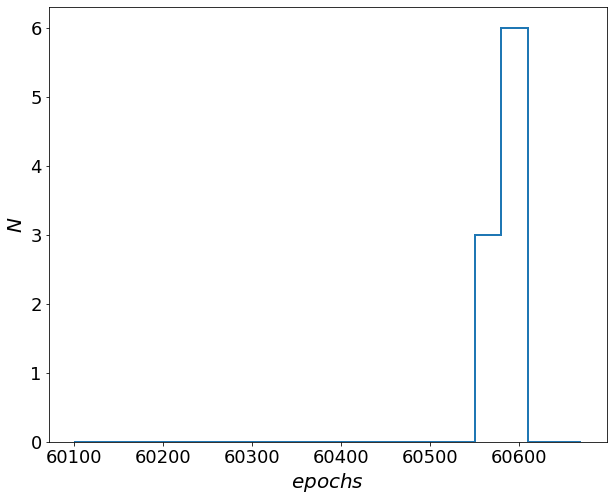

[35.127288813258936, -5.054239325757356]


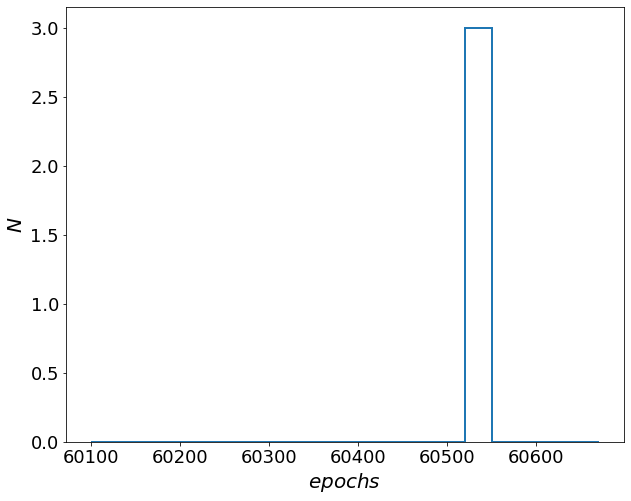

[35.70563992477028, -4.92522863652468]


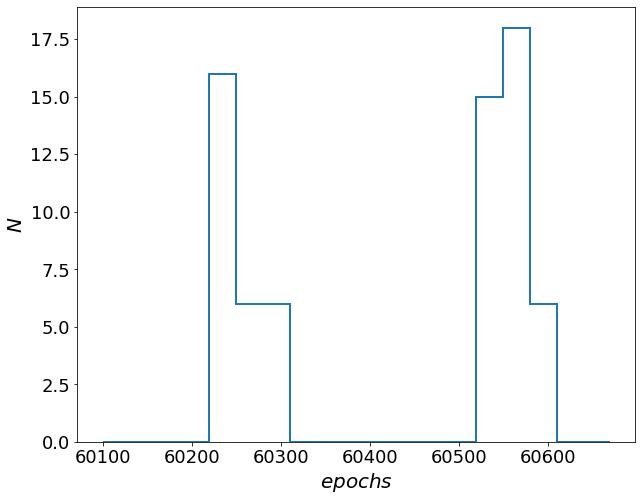

[53.361510401036284, -27.576026424452976]


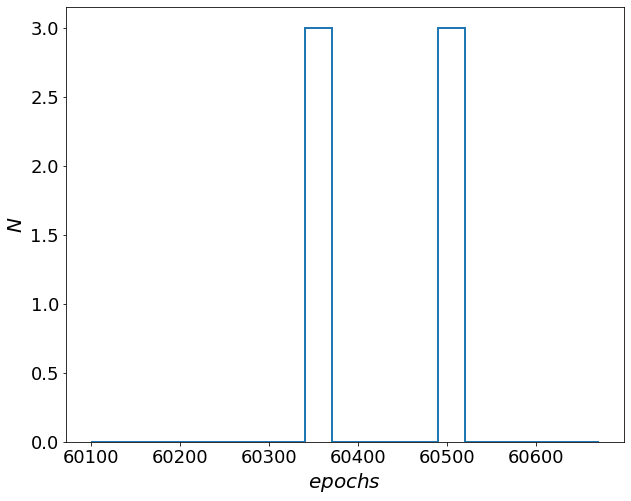

[53.12567139727727, -28.122967959651497]


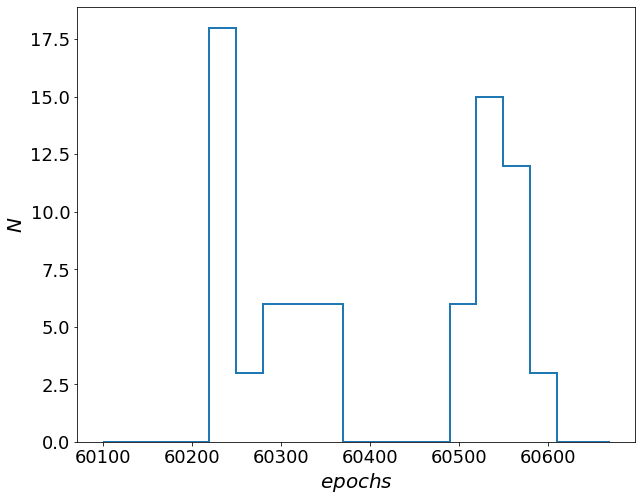

[53.44519366438403, -28.01589577520734]


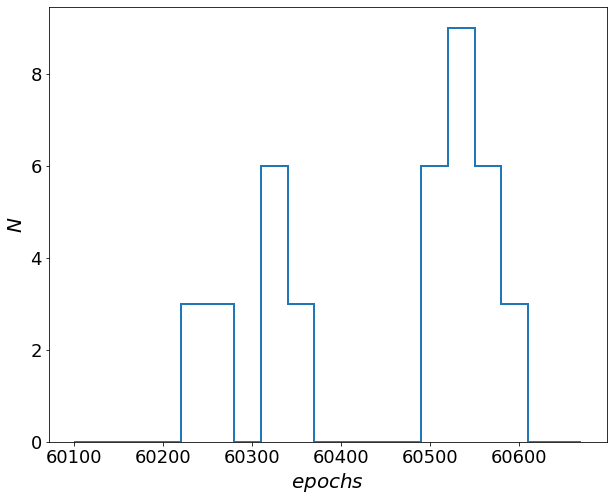

[53.16362465874926, -28.16637276864145]


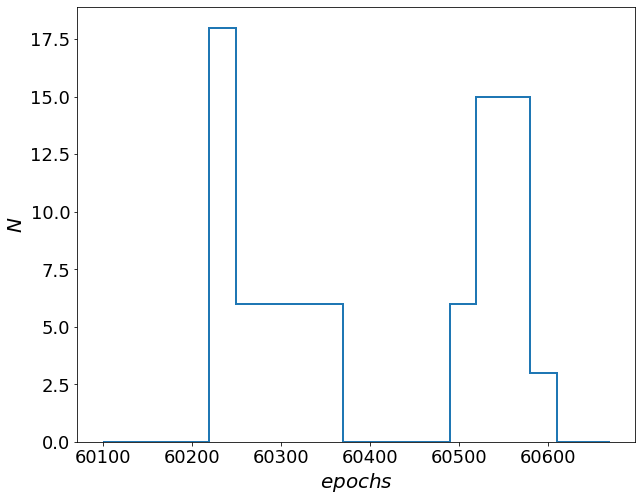

[53.0118993644043, -28.664770354121295]


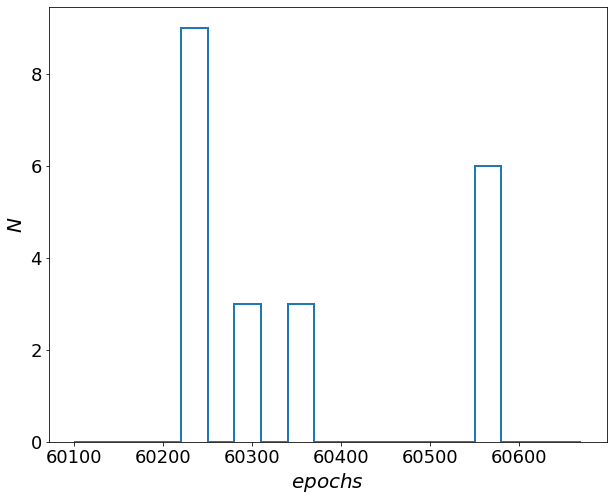

[9.653768217442474, -43.455772311777565]


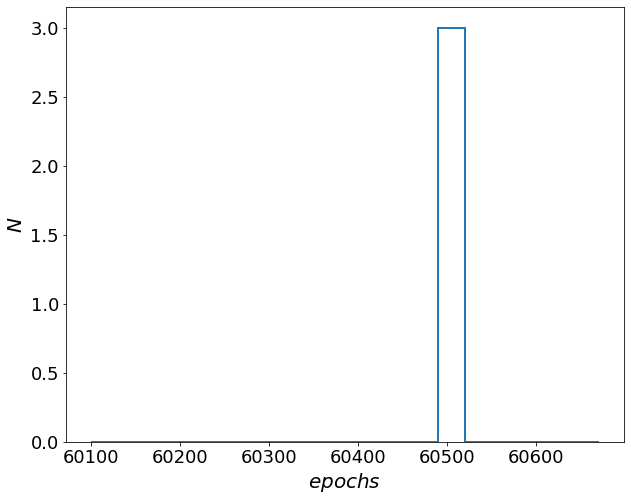

[9.179262999256796, -43.97616973556157]


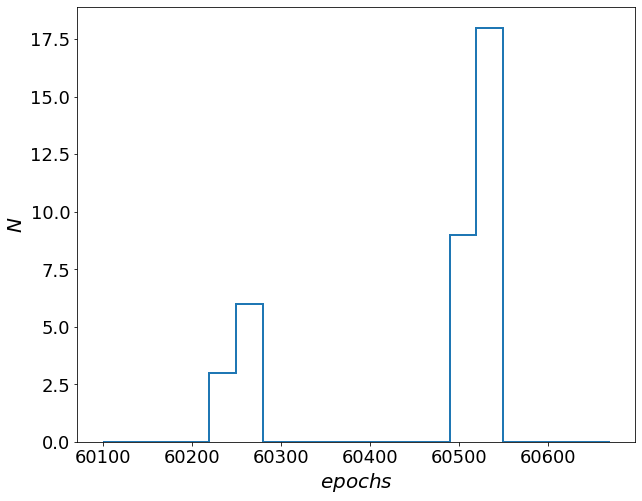

[9.576144658002292, -44.05510492684386]


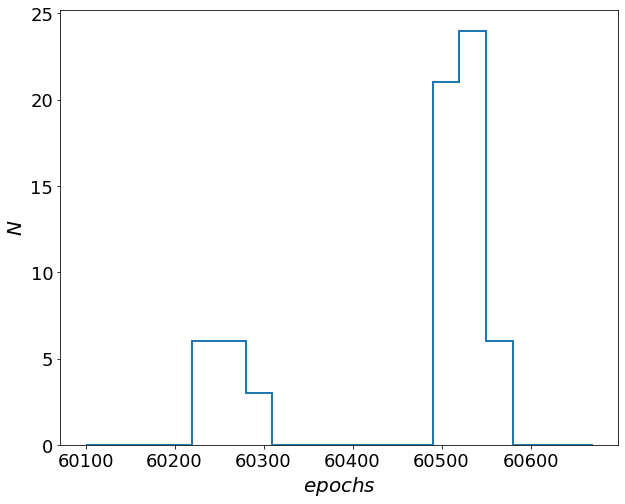

[9.10306028330164, -44.09234047992187]


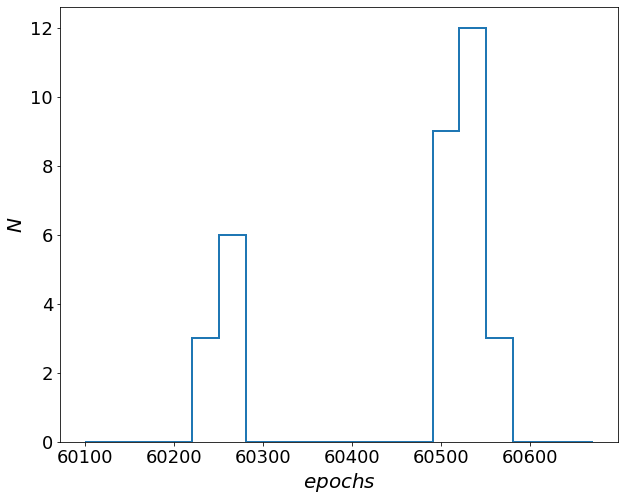

[9.576144658002292, -44.05510492684386]


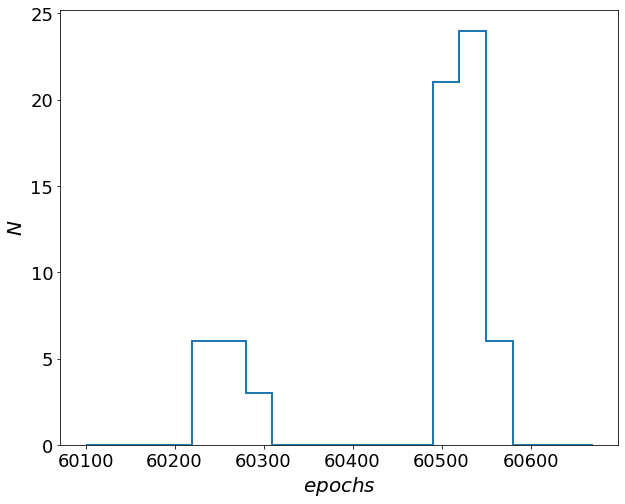

[63.088916787755146, -47.76841383804285]


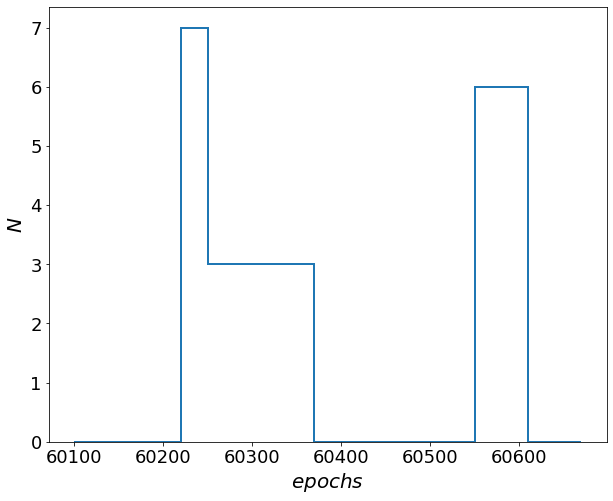

[59.256856762451385, -49.250049788814636]


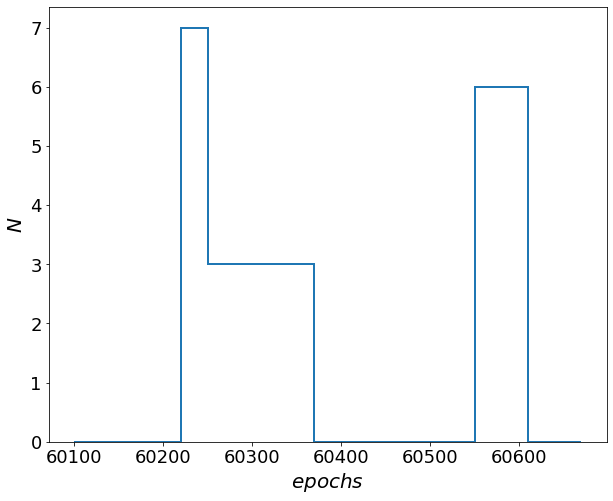

[63.088916787755146, -47.76841383804285]


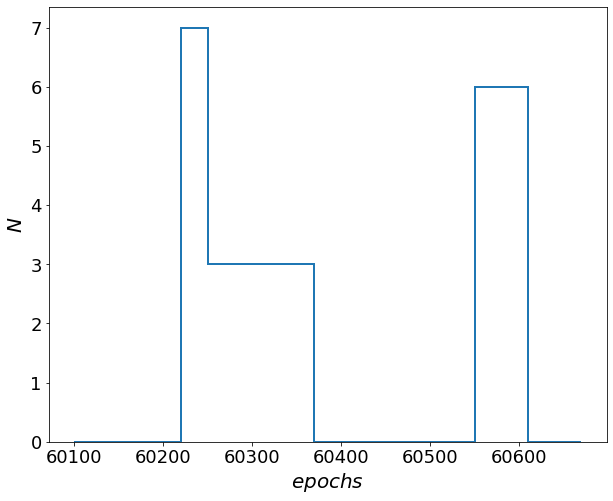

[63.61191270138353, -47.64681822523917]


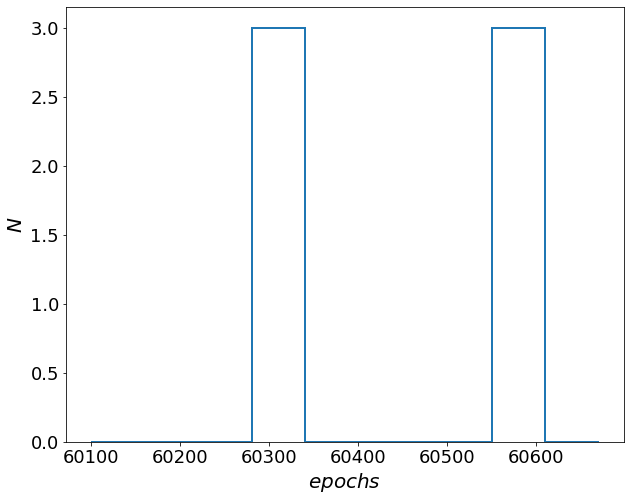

[59.256856762451385, -49.250049788814636]


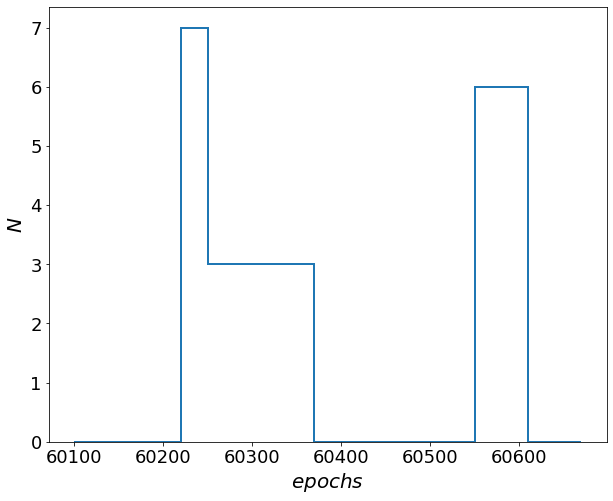

[59.25779345994895, -49.266844112256145]


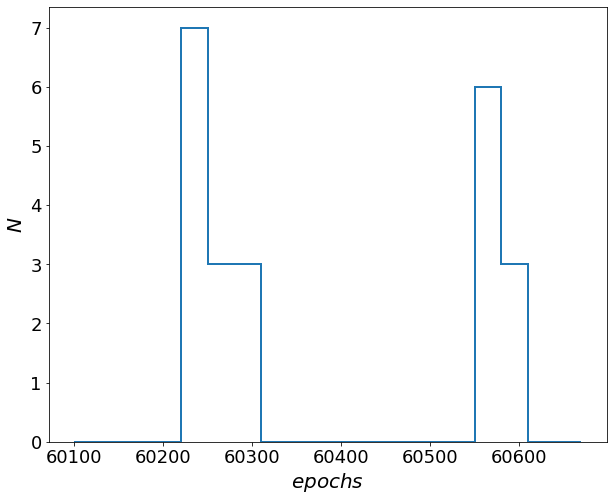

____________________
NSIDE =64
____________________
[150.01214914881544, 2.7952828892015678]


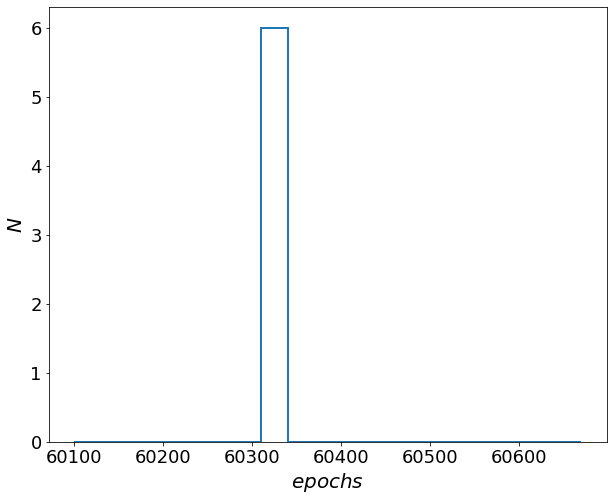

[150.04194504502777, 2.6914711491729486]


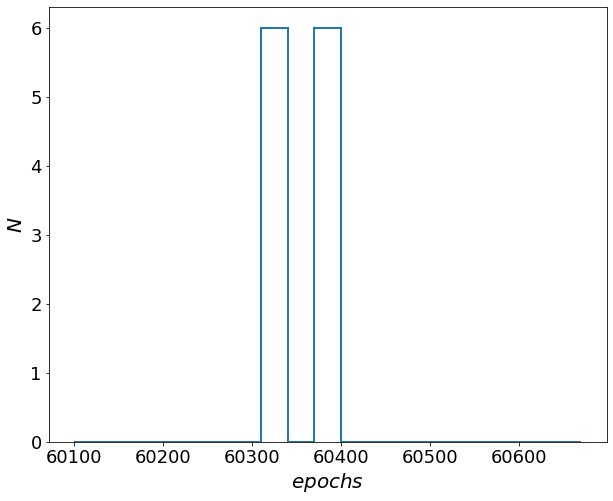

[149.63340761400258, 2.4124127990877304]


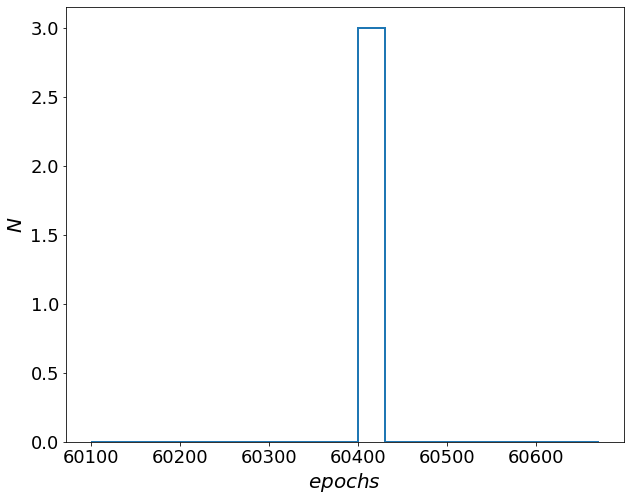

[149.9918047107118, 2.3081259548917954]


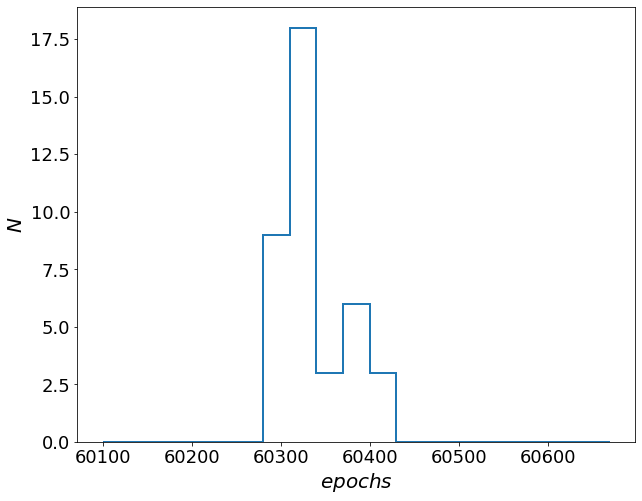

[150.0882929796595, 2.65503710238609]


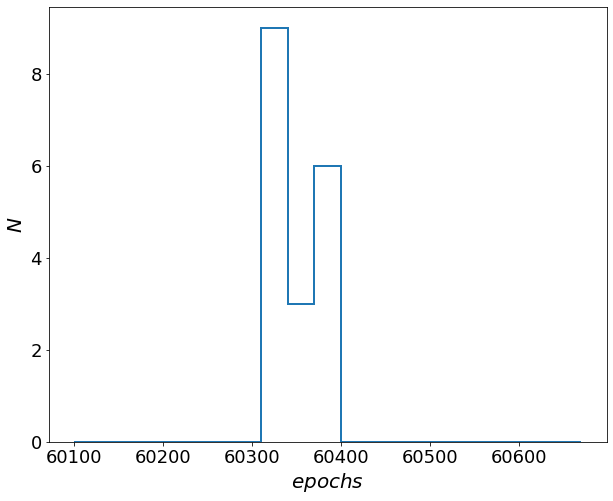

[149.9918047107118, 2.2626557766018447]


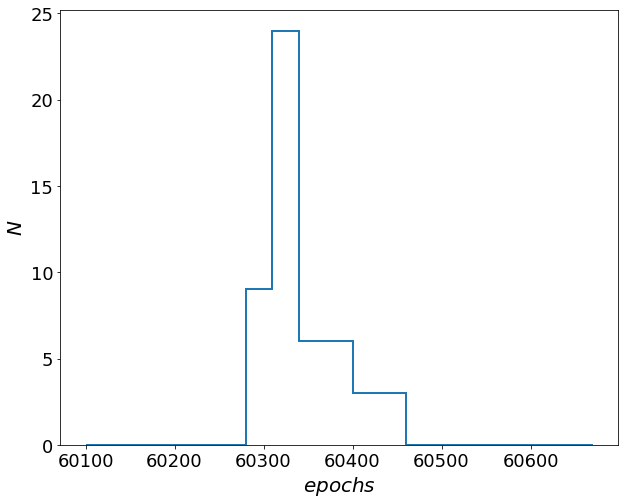

[150.0845005799753, 2.0592021423250273]


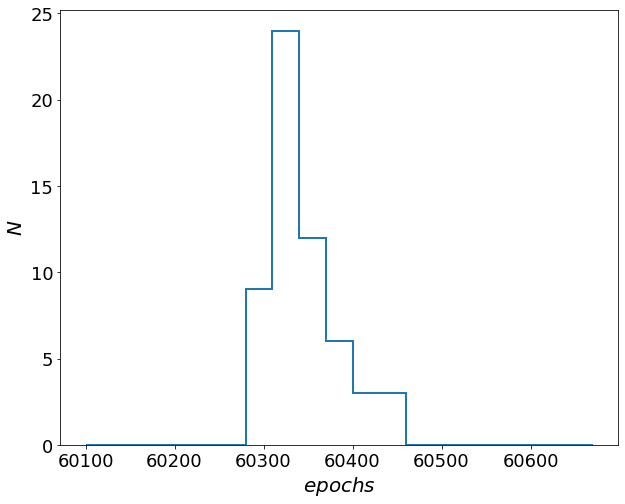

[150.57487392655912, 2.3491033098029654]


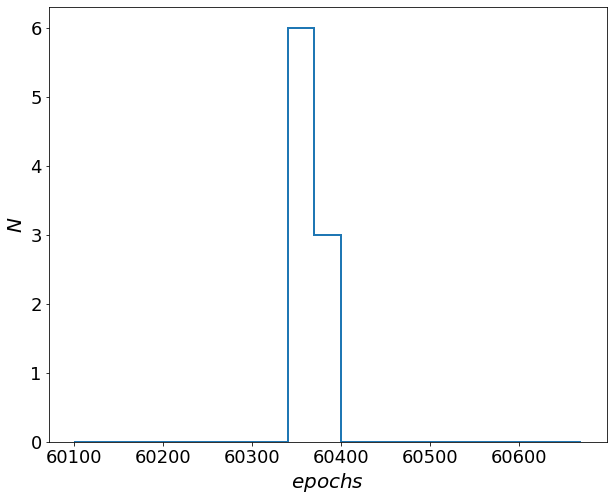

[149.77211669957615, 2.2815743072073946]


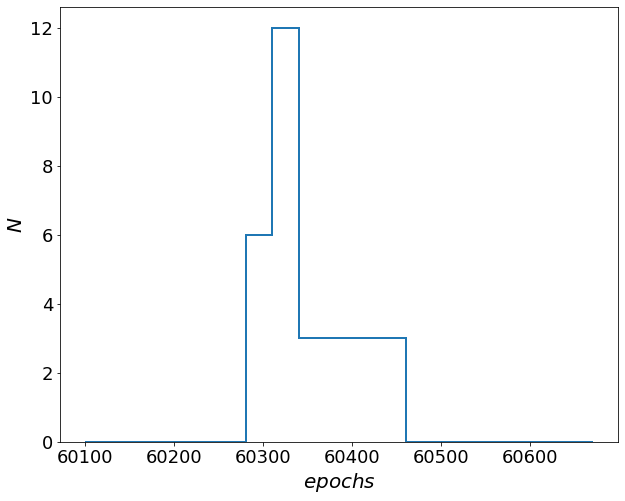

[150.0845005799753, 2.0592021423250273]


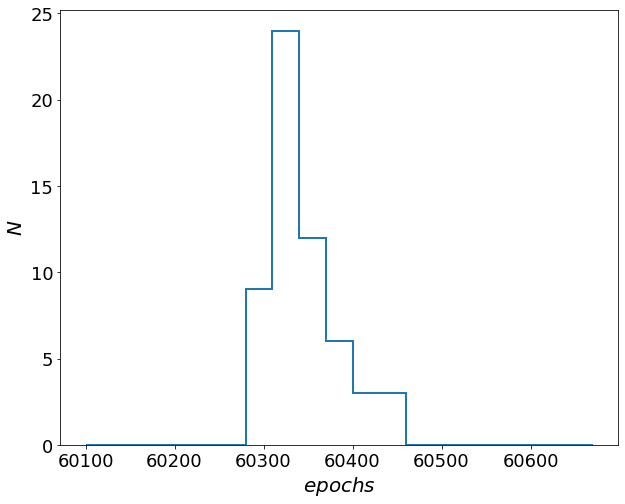

[150.0845005799753, 2.0592021423250273]


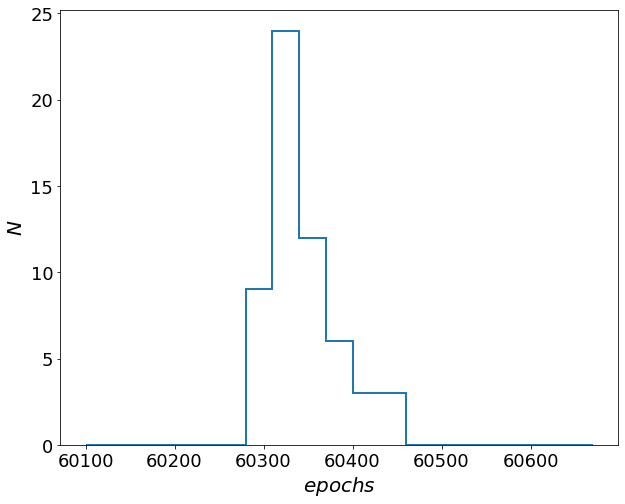

[149.9918047107118, 2.0592021423250273]


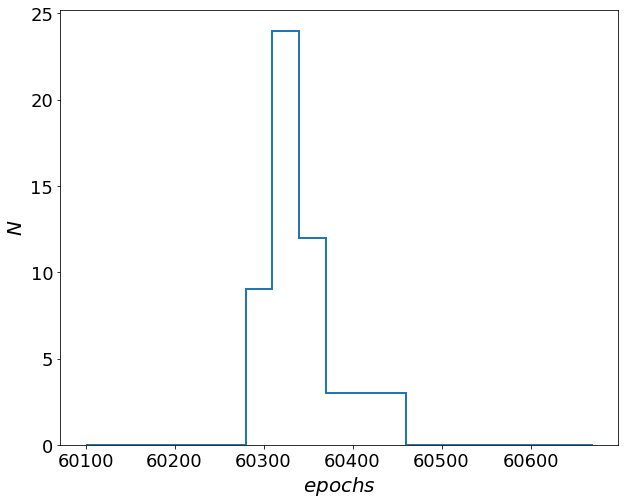

[150.0845005799753, 2.0592021423250273]


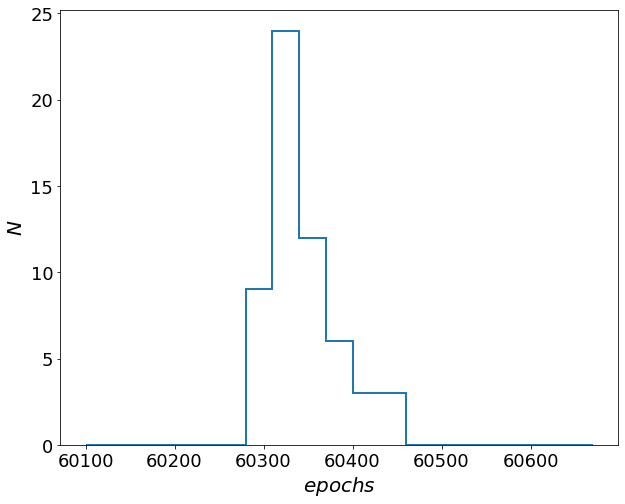

[150.3537683359455, 1.9314822096313506]


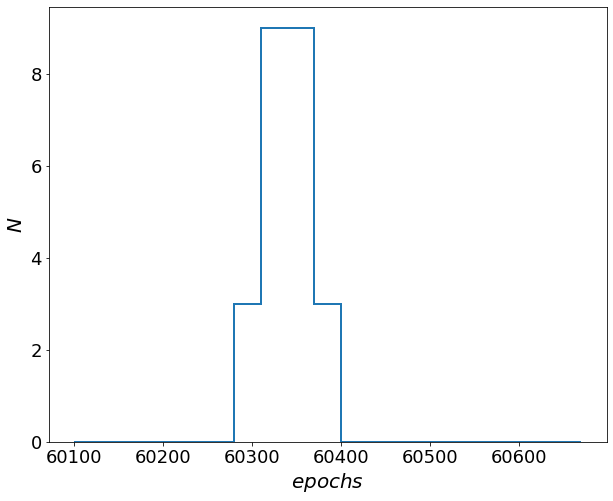

[149.7336893216446, 1.9647874790730027]


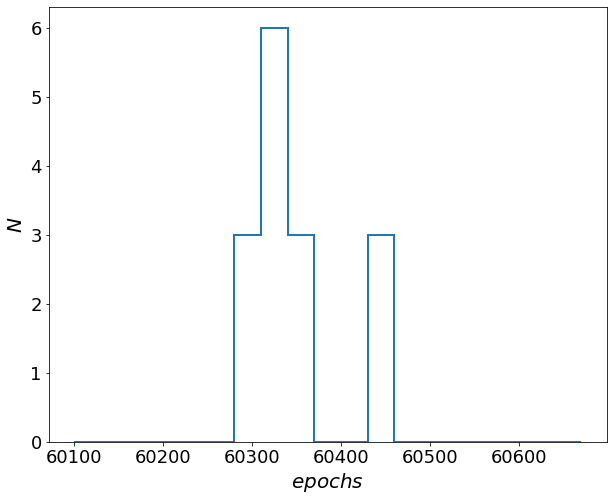

[150.0845005799753, 2.0592021423250273]


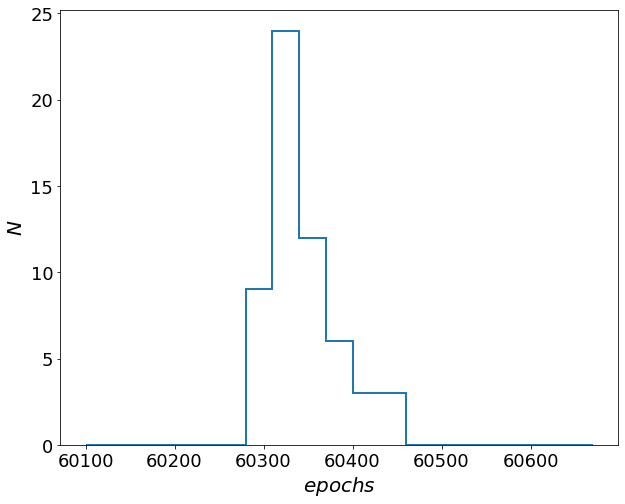

[150.19981754631073, 1.9314822096313506]


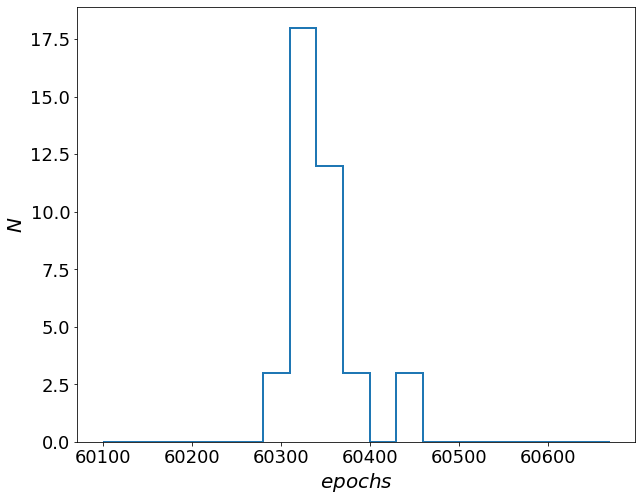

[149.81054407750767, 1.7213618580725147]


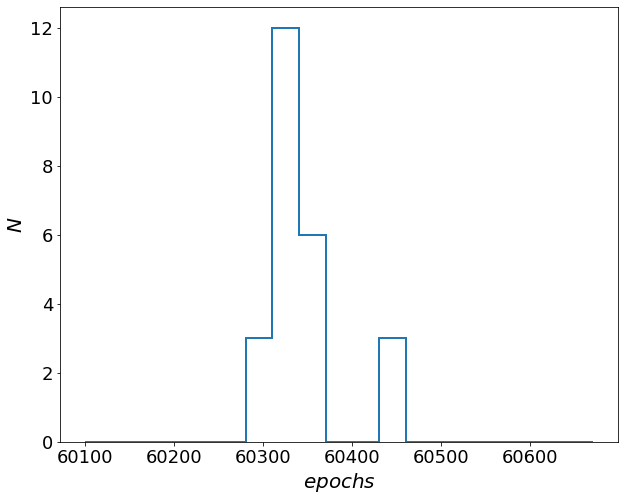

[150.15840077410166, 1.8412100177401596]


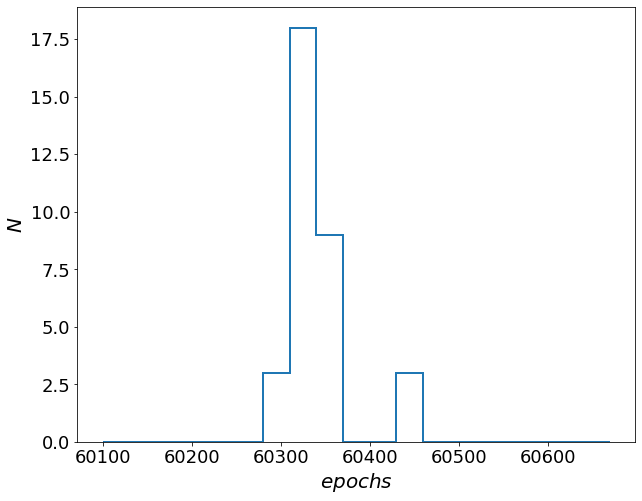

[149.87747994943246, 1.5947670521750508]


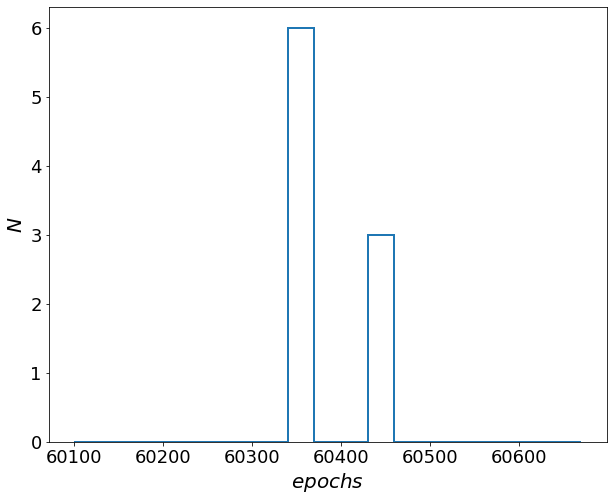

[35.56760910251104, -4.395673534635733]


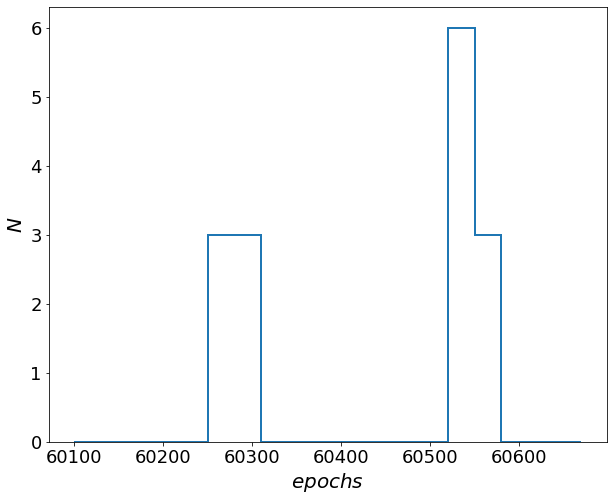

[36.00892573943949, -4.395673534635733]


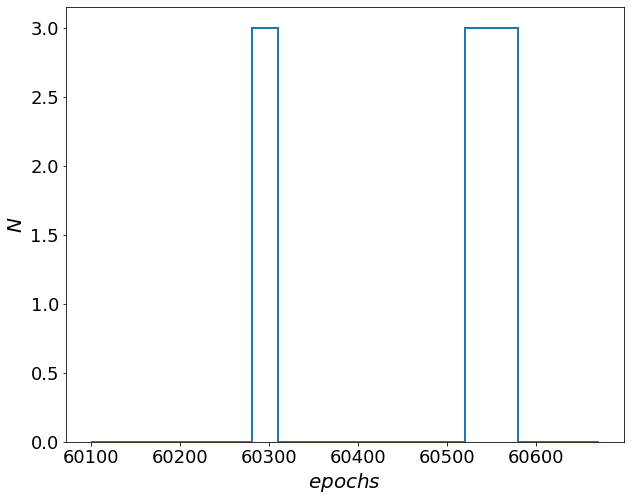

[35.35459227221697, -4.77123529442127]


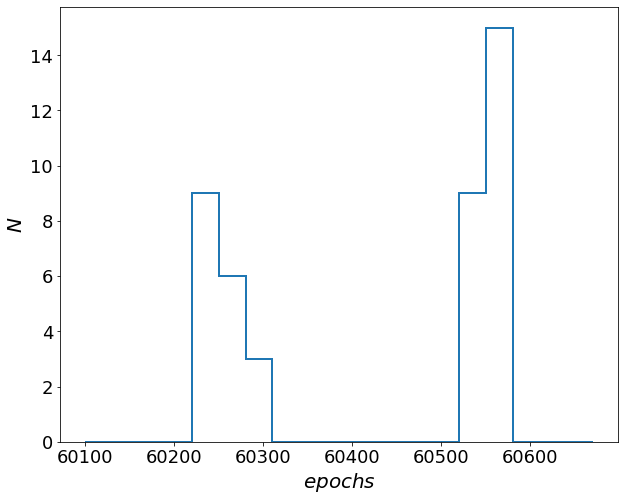

[35.67587285492021, -4.816873804249979]


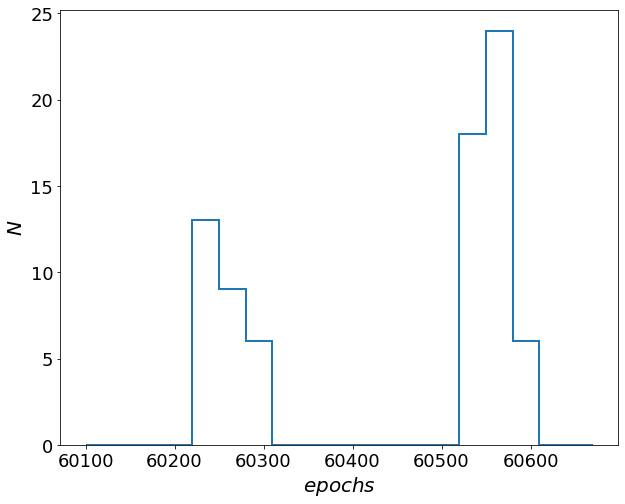

[36.20919963958971, -4.606426151032467]


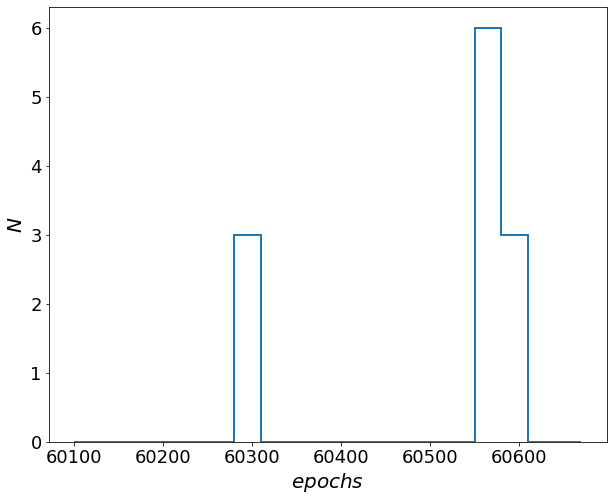

[35.249337470508856, -4.79539779610899]


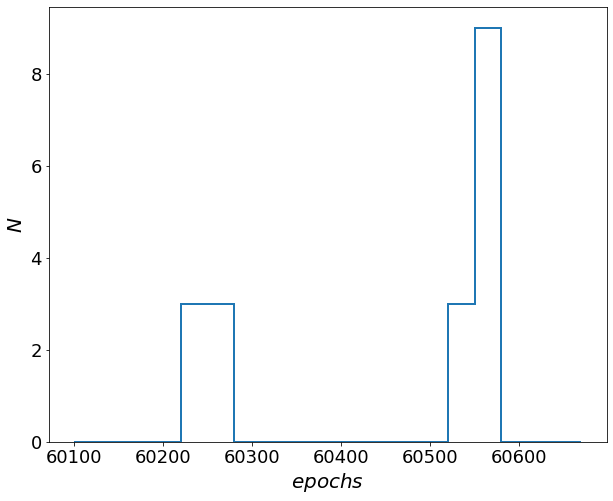

[35.67587285492021, -4.8825792814816005]


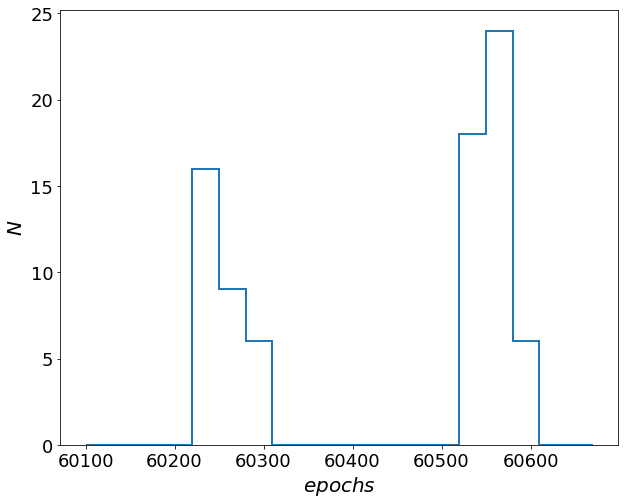

[35.67587285492021, -4.8825792814816005]


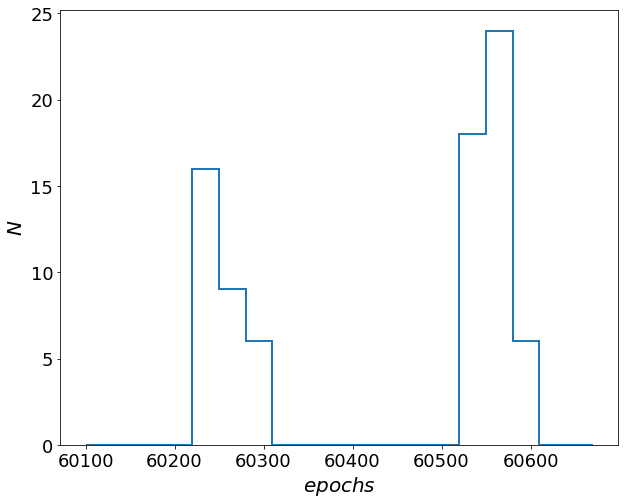

[36.34446550872291, -4.475055703690947]


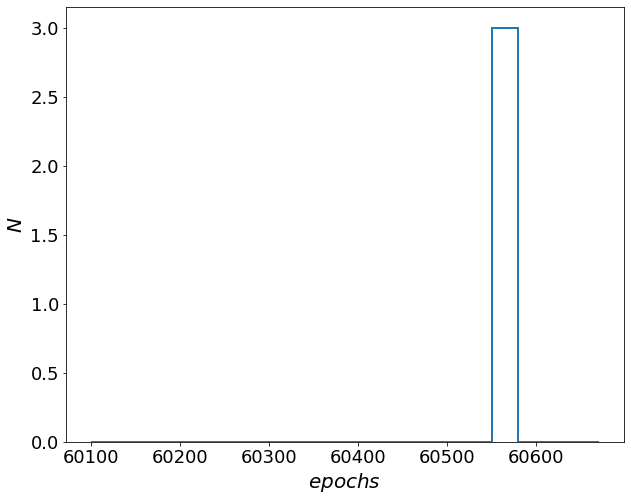

[35.608761067012885, -4.8825792814816005]


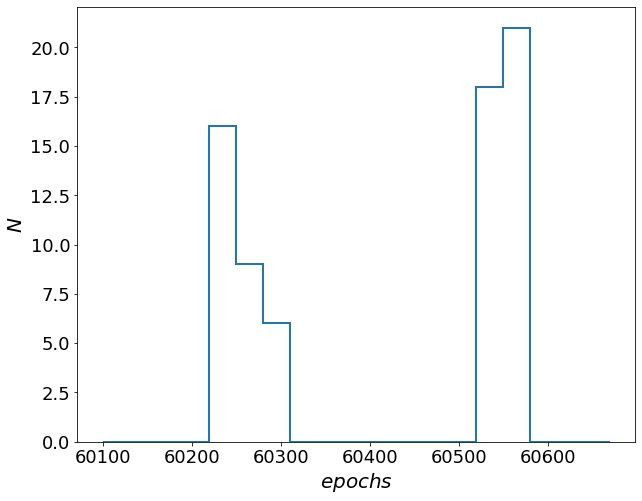

[35.67587285492021, -4.8825792814816005]


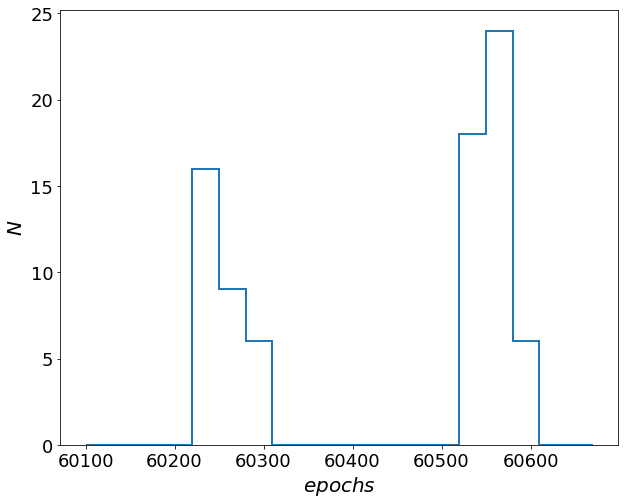

[35.83919611047315, -4.762289940231978]


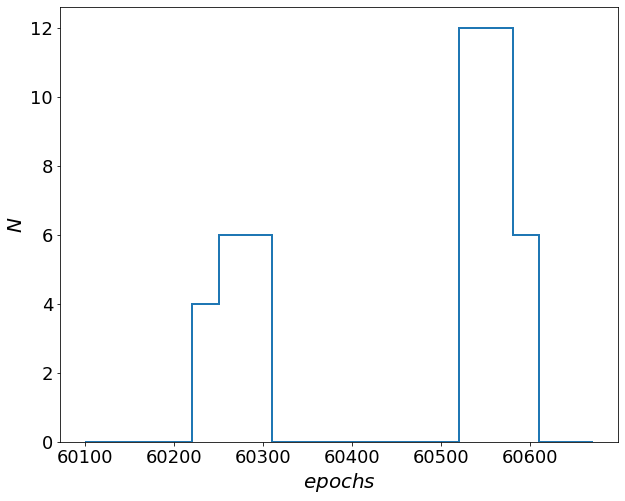

[35.33523120128823, -4.991883718426869]


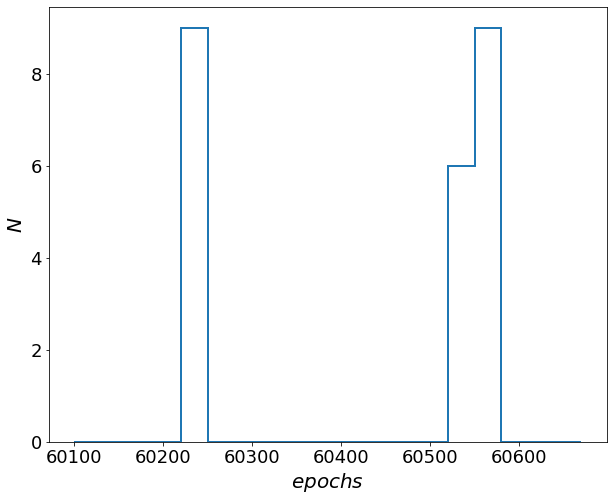

[35.67587285492021, -4.8825792814816005]


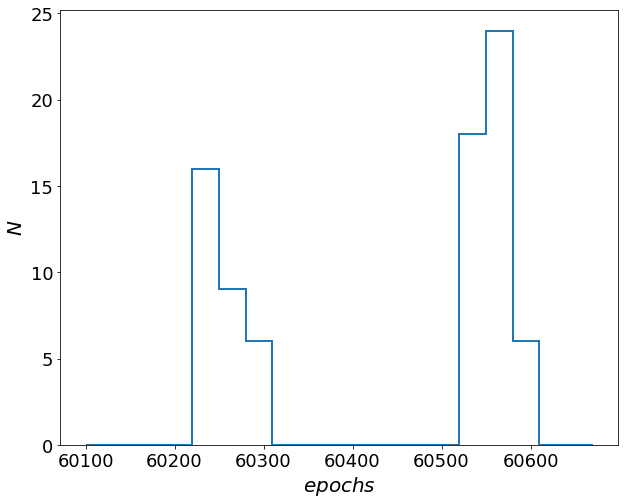

[35.67587285492021, -4.8825792814816005]


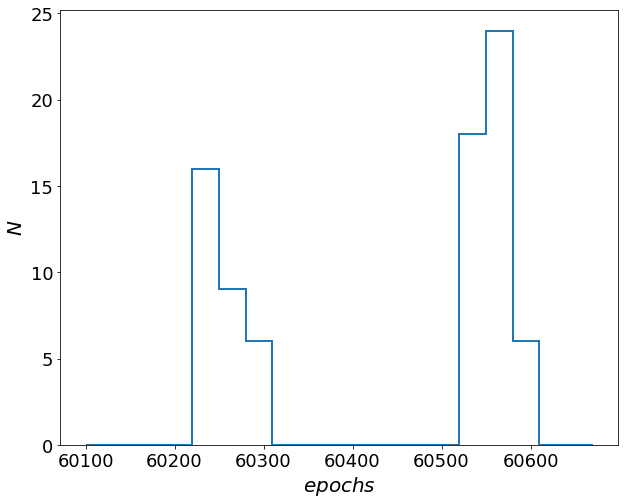

[36.276739581361284, -5.040000233649861]


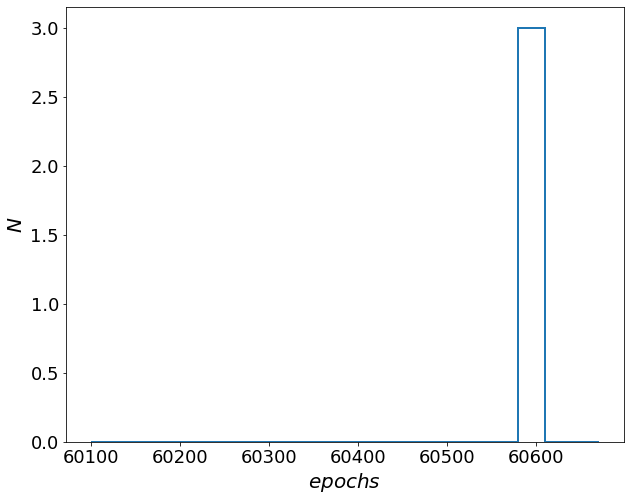

[35.411599060613405, -4.9910074535743885]


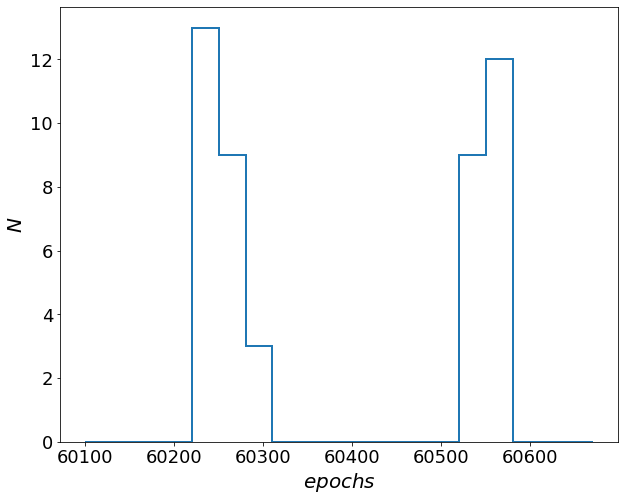

[35.67587285492021, -4.8825792814816005]


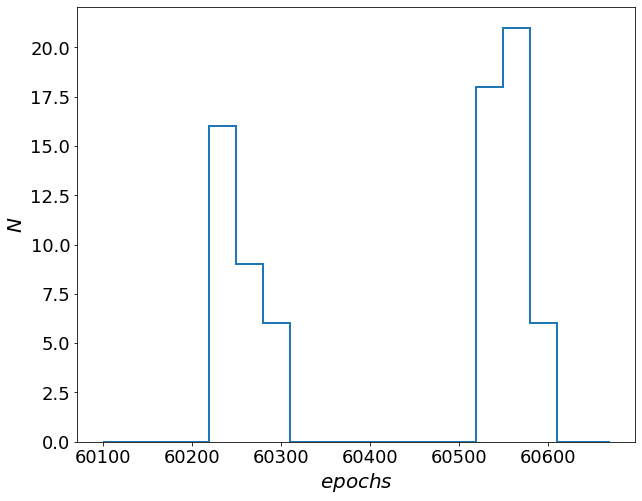

[35.766813584164616, -5.1082359608984325]


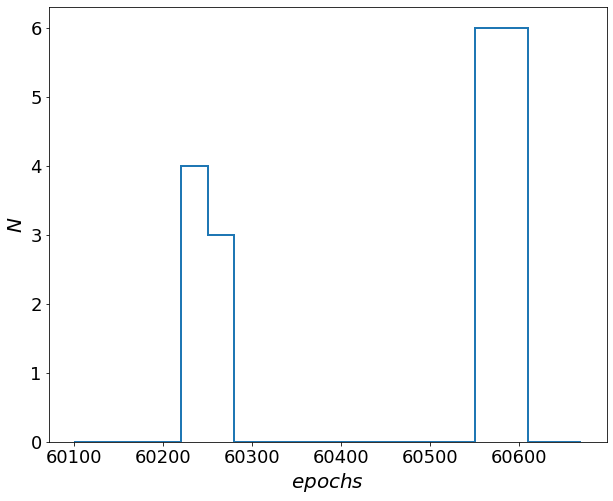

[35.35884279386135, -5.09271382798562]


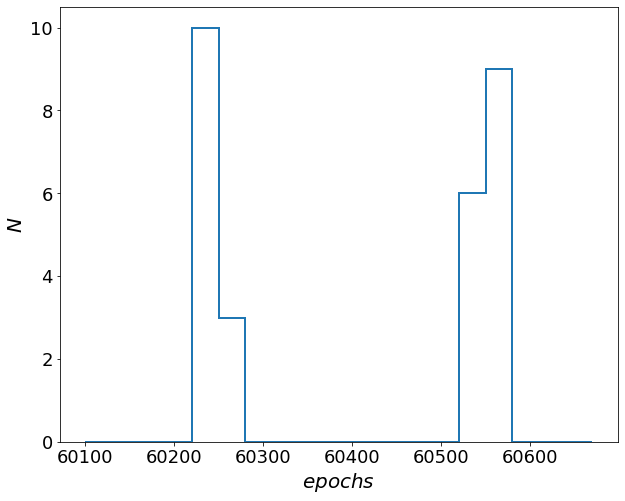

[35.75093446983255, -5.235058002223863]


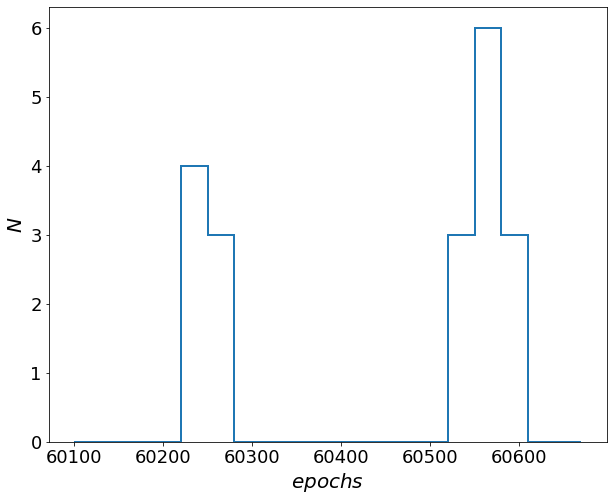

[53.29184298984515, -27.555853590596506]


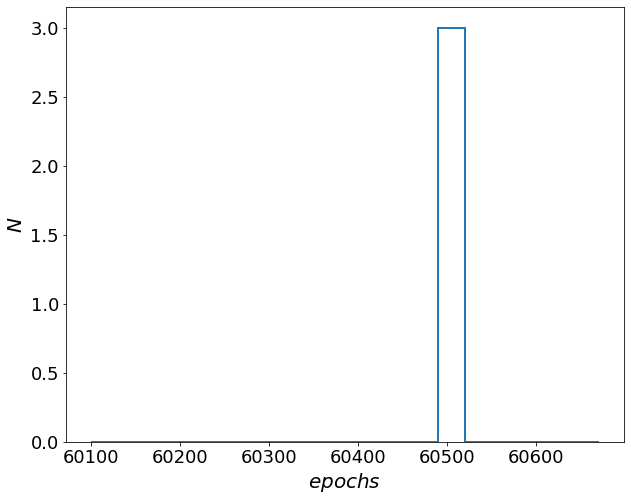

[52.96619629963267, -27.94125405400456]


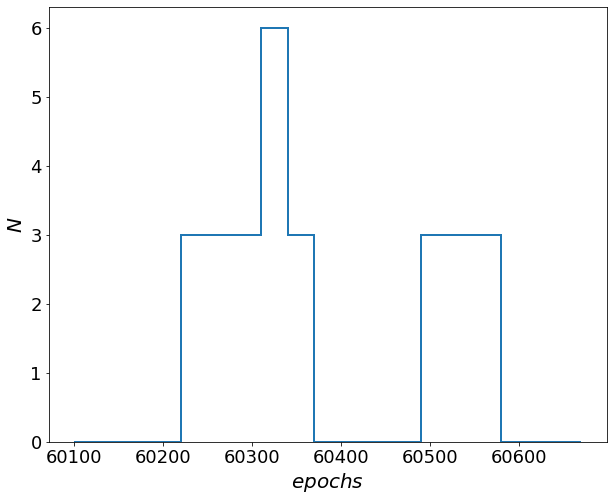

[53.280283465637446, -28.002228883136574]


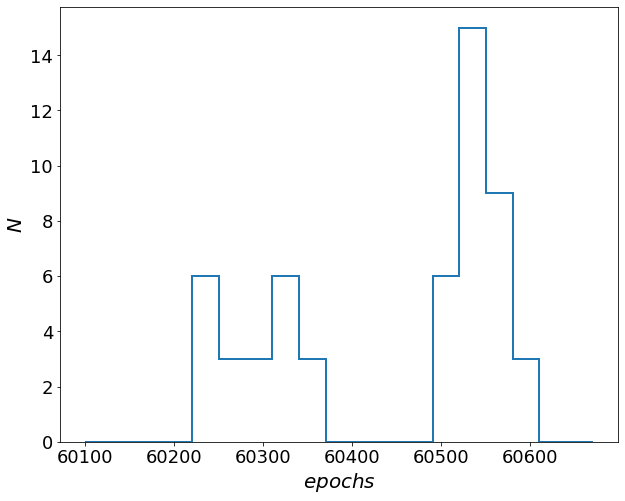

[53.43117781222741, -27.596199258309447]


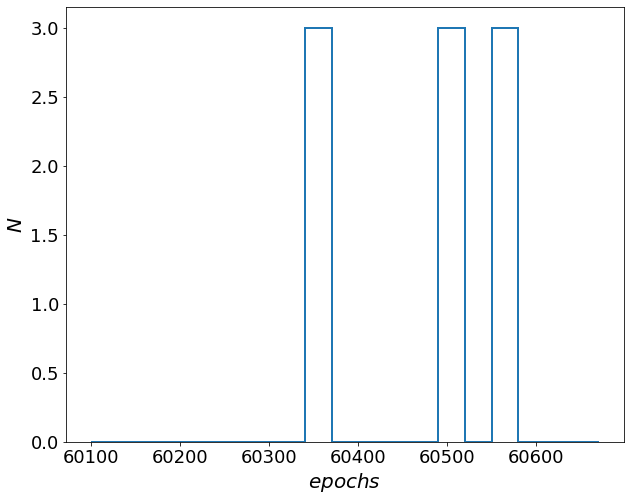

[52.74087526420588, -28.040893771295284]


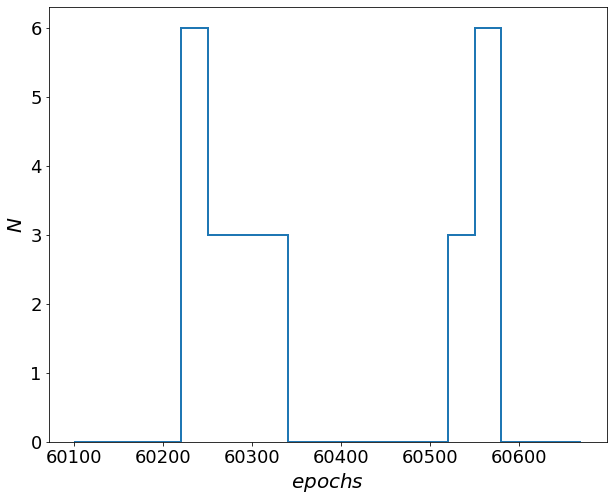

[53.16362465874926, -28.16637276864145]


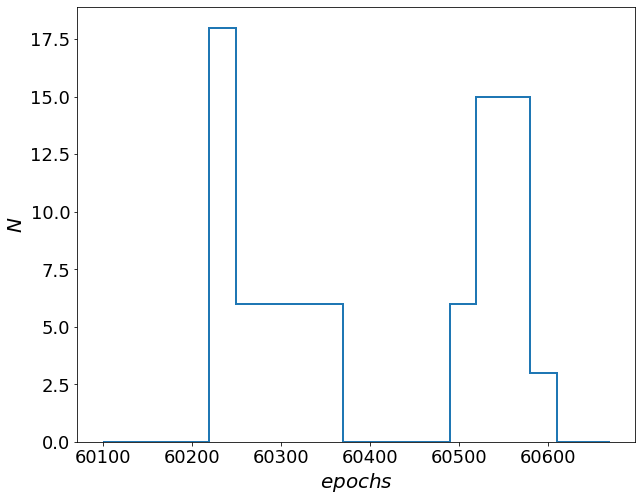

[53.19136246875506, -28.122967959651497]


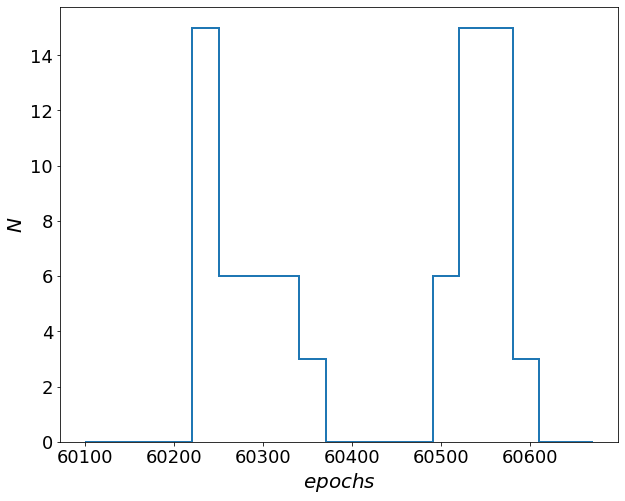

[53.84210090697379, -27.823477921967743]


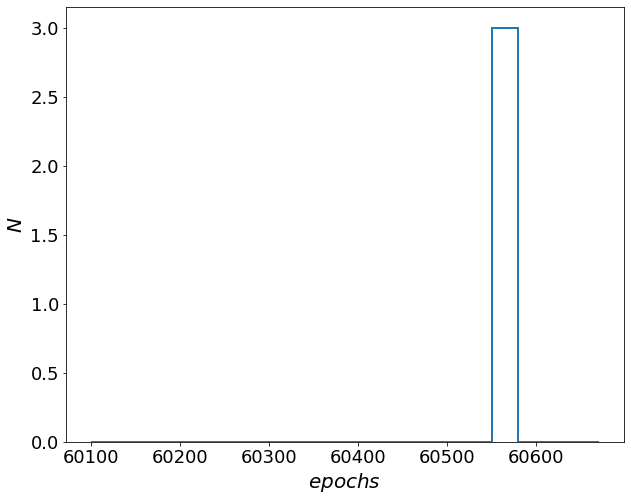

[52.566784446521204, -28.122967959651497]


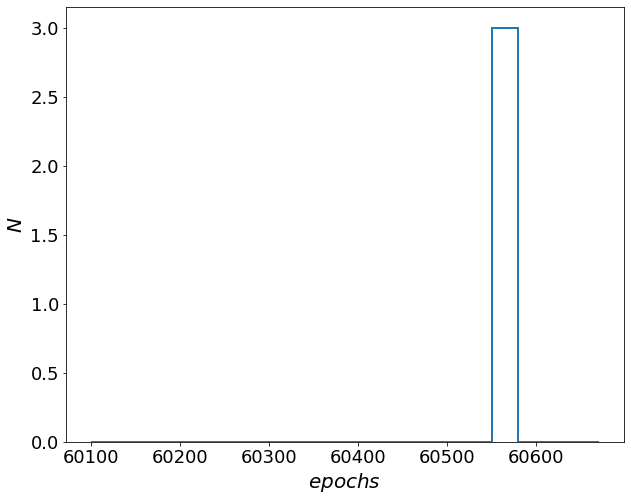

[53.16362465874926, -28.16637276864145]


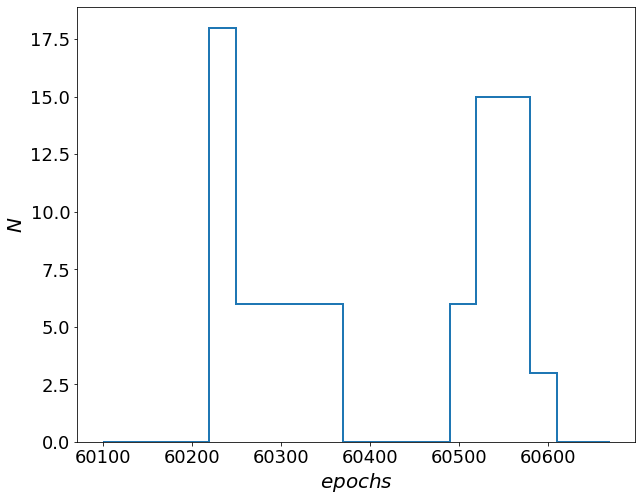

[53.16362465874926, -28.16637276864145]


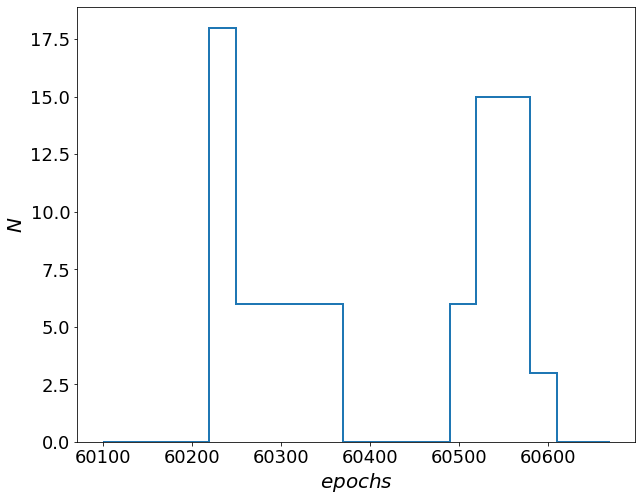

[53.289833818231244, -28.09348753748086]


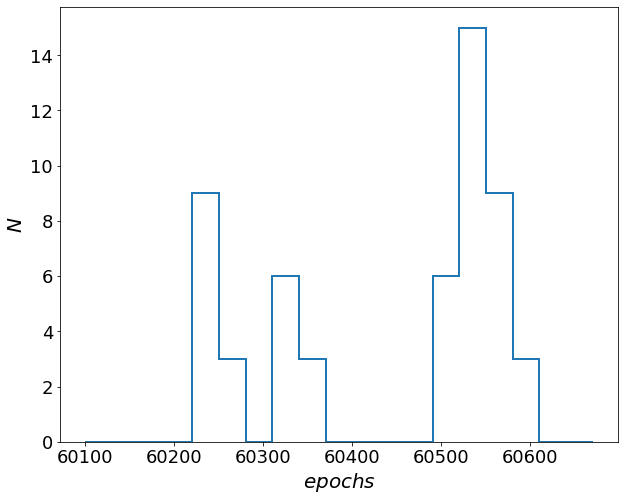

[52.82689435848171, -28.340529275147762]


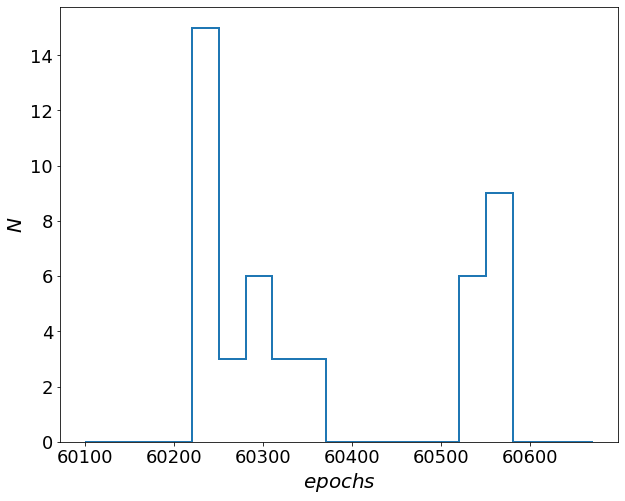

[53.16362465874926, -28.16637276864145]


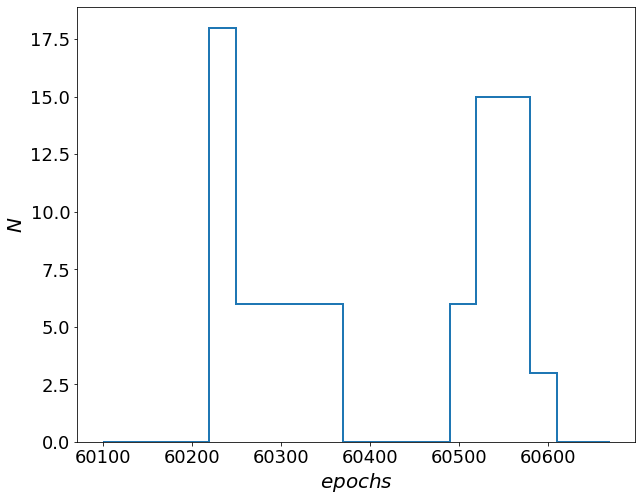

[53.16362465874926, -28.16637276864145]


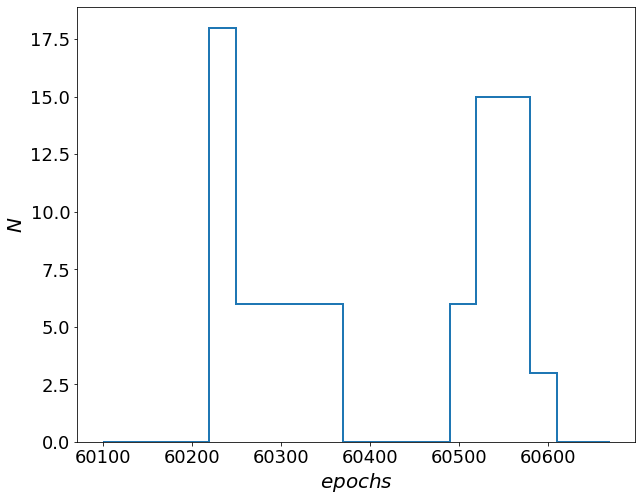

[53.703633321965384, -28.086771426470644]


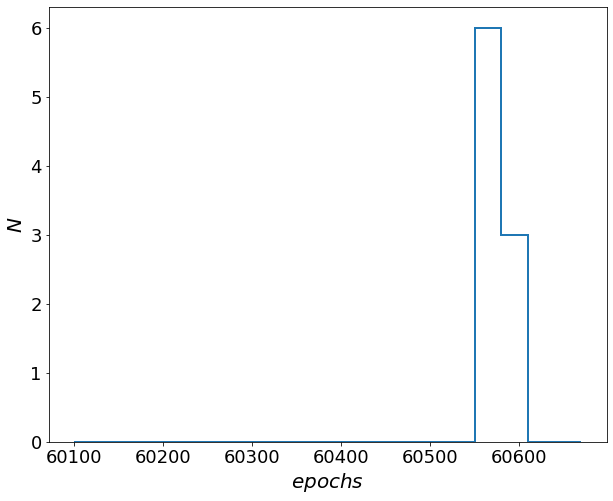

[53.02649697976553, -28.236707232138947]


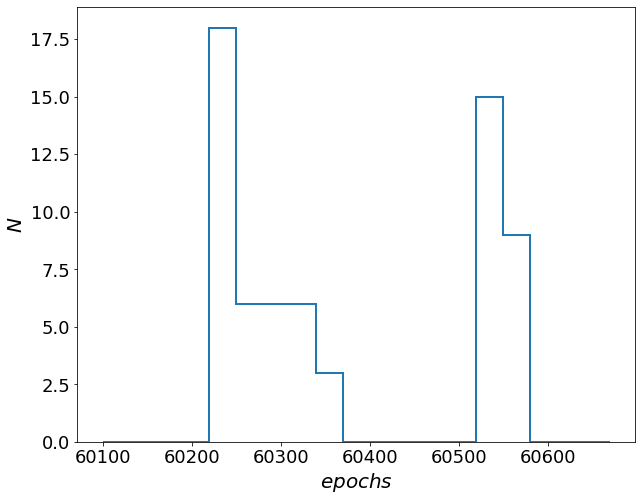

[53.144648028013265, -28.19943548308865]


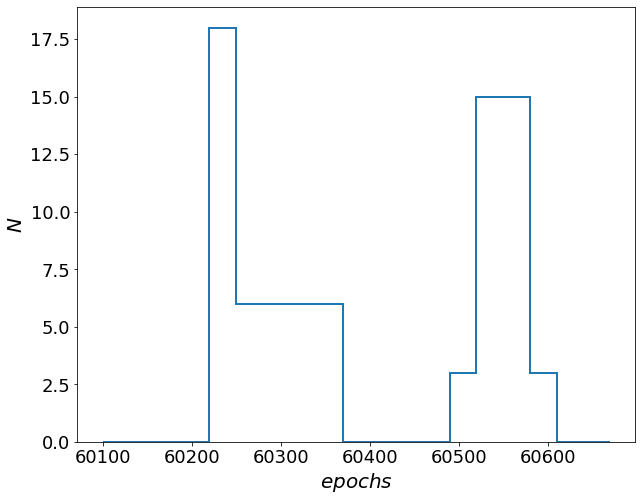

[53.453643098145555, -28.284058807772656]


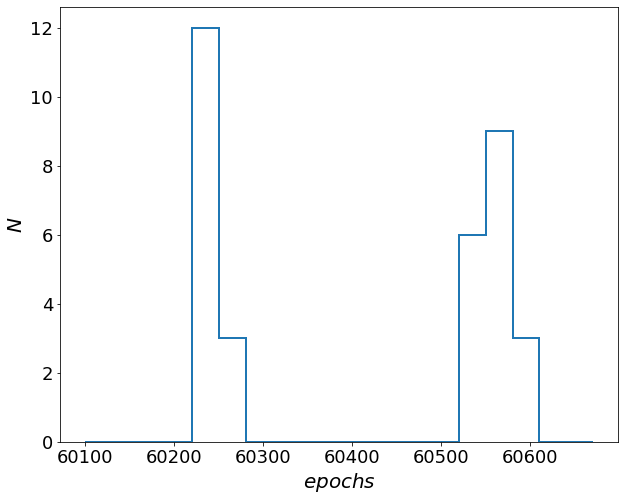

[53.0118993644043, -28.585053452183445]


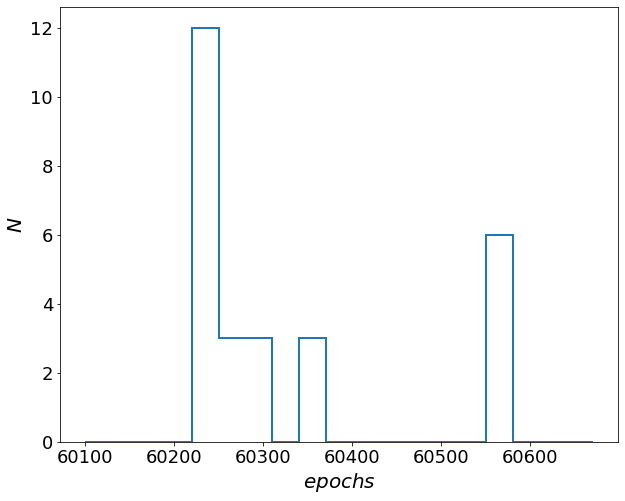

[53.16362465874926, -28.664770354121295]


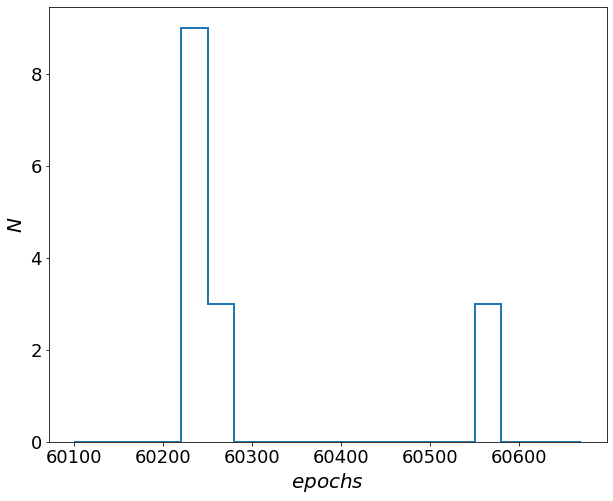

[9.653768217442474, -43.455772311777565]


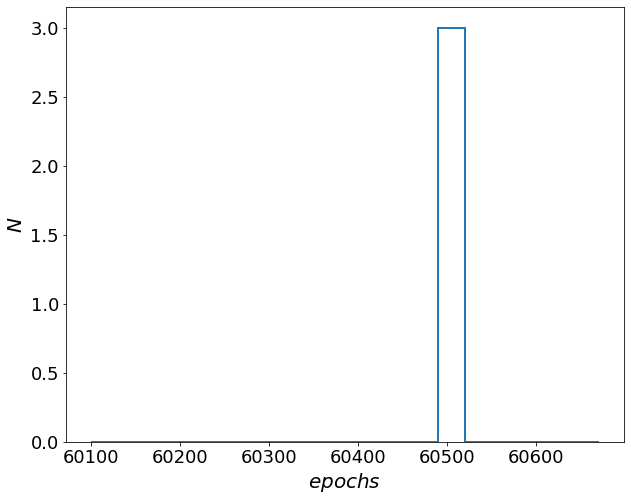

[9.147441240409982, -43.88261238087303]


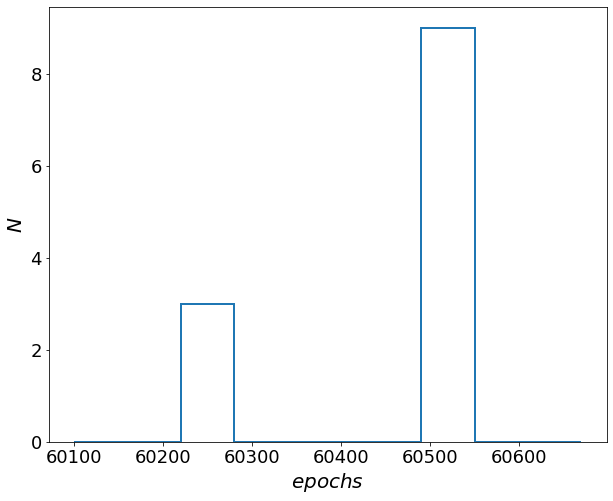

[9.616108391857182, -43.987193938624024]


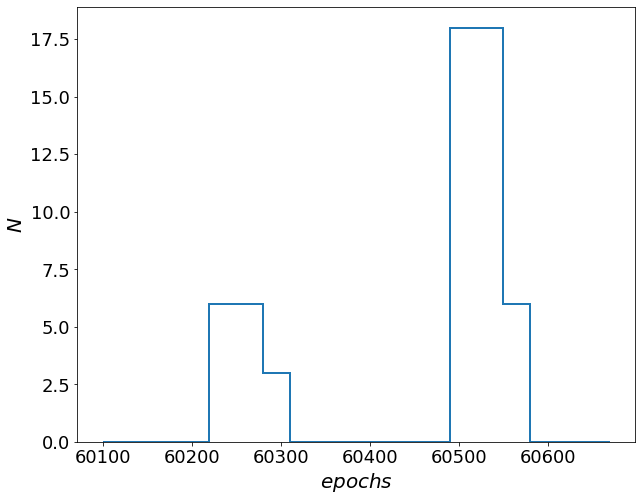

[9.710911435075733, -43.8379937354023]


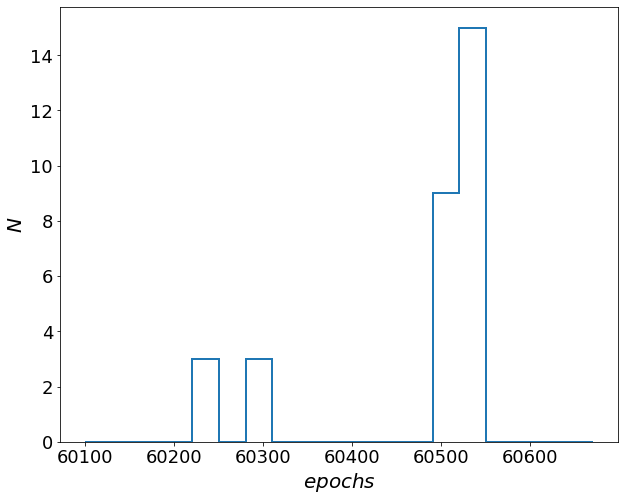

[8.69978525352675, -43.90647903548574]


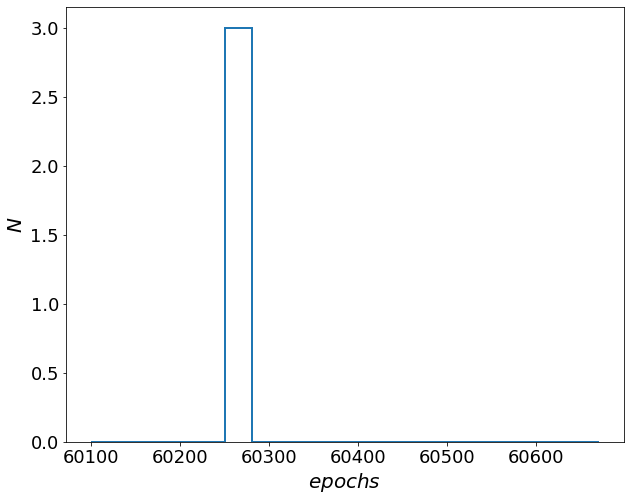

[9.576144658002292, -44.05510492684386]


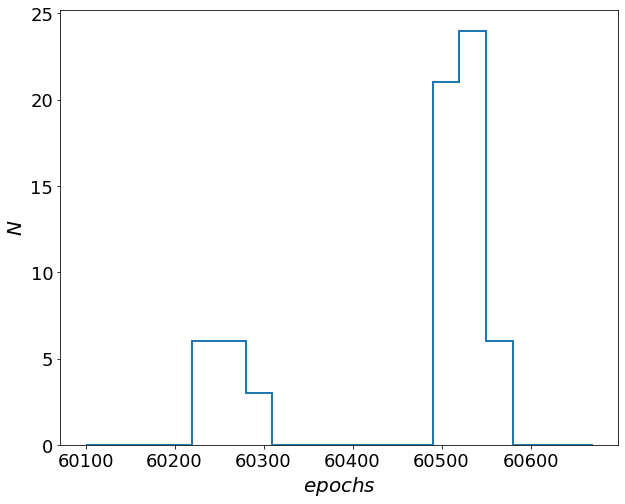

[9.576144658002292, -44.05510492684386]


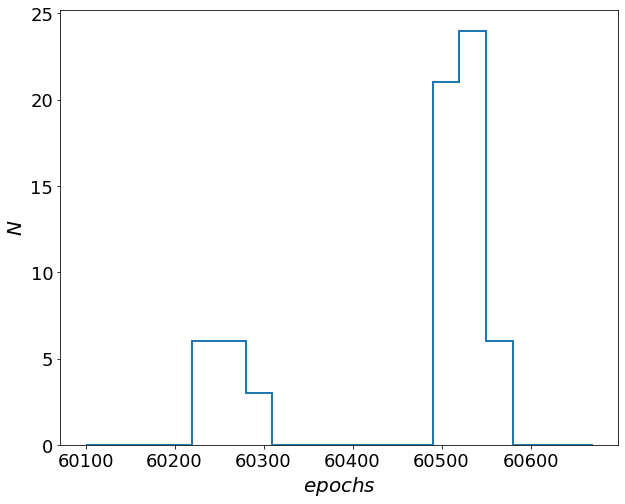

[9.616108391857182, -44.01786937376585]


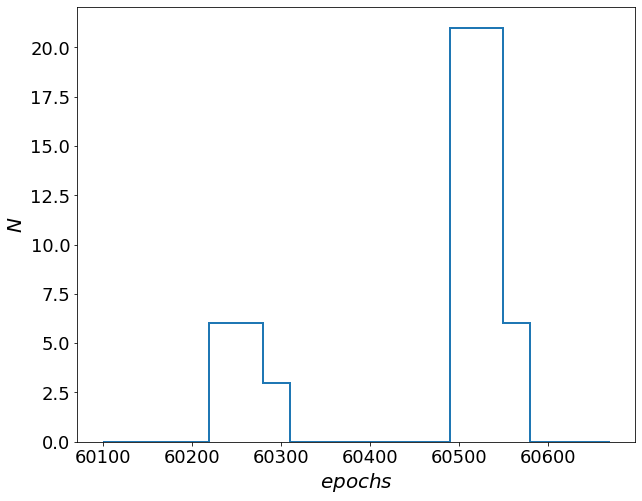

[10.221615783184996, -43.724880892012926]


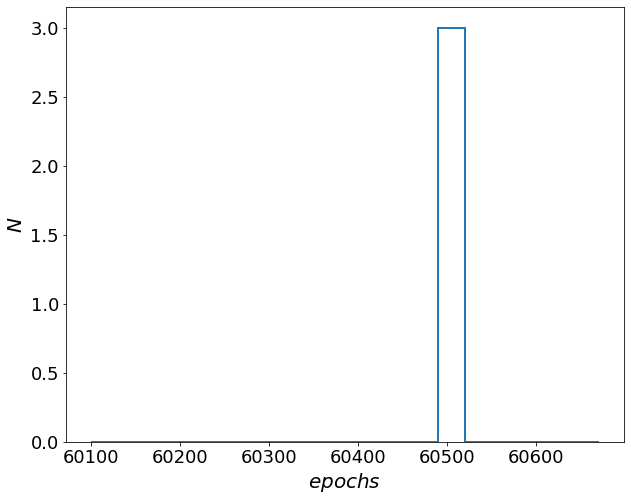

[8.872049335651777, -43.987193938624024]


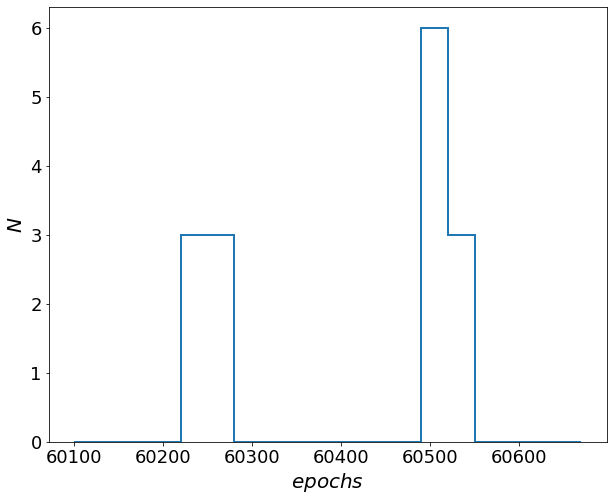

[9.576144658002292, -44.05510492684386]


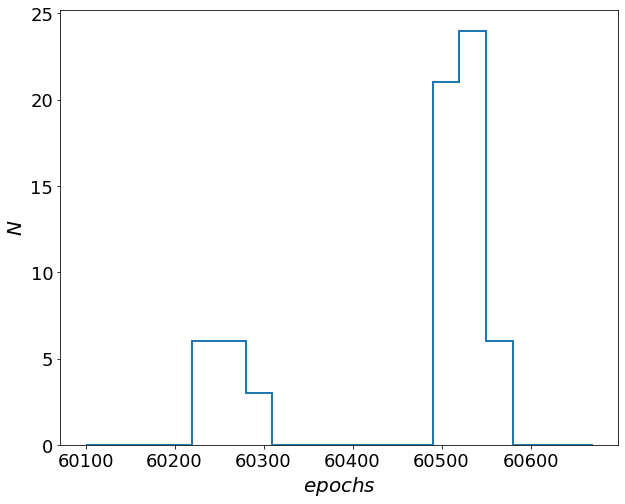

[9.576144658002292, -44.05510492684386]


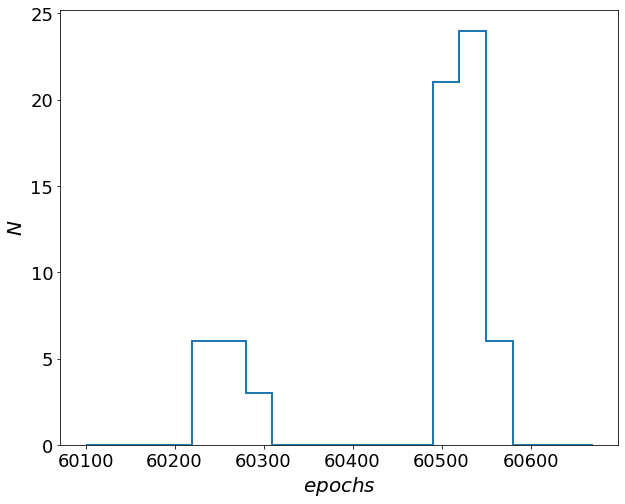

[9.576144658002292, -44.05510492684386]


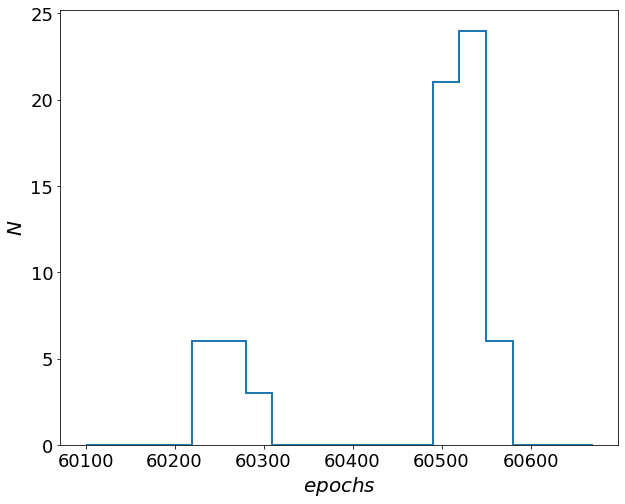

[10.221615783184996, -43.724880892012926]


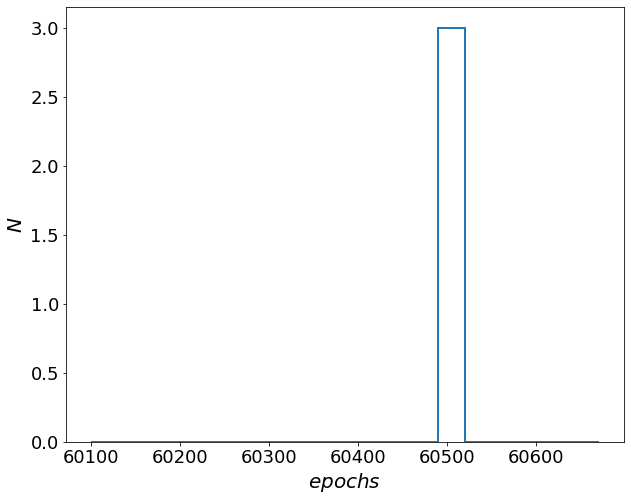

[8.87215936541877, -44.40670057829362]


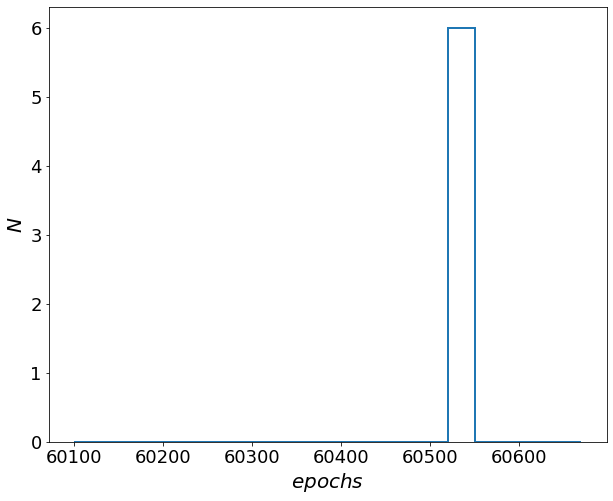

[9.470558037645787, -44.109119439816745]


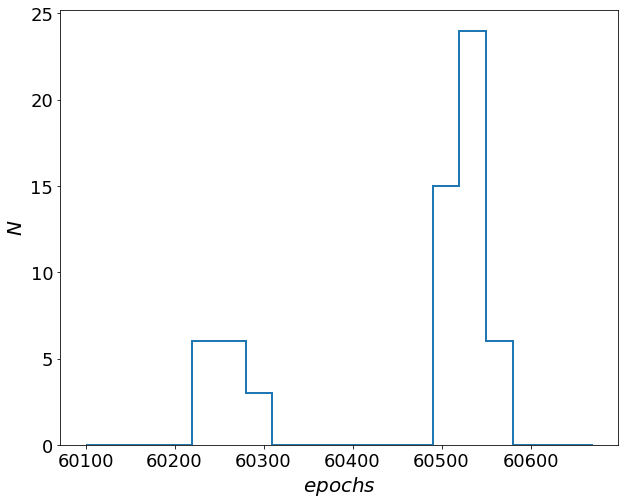

[9.576144658002292, -44.05510492684386]


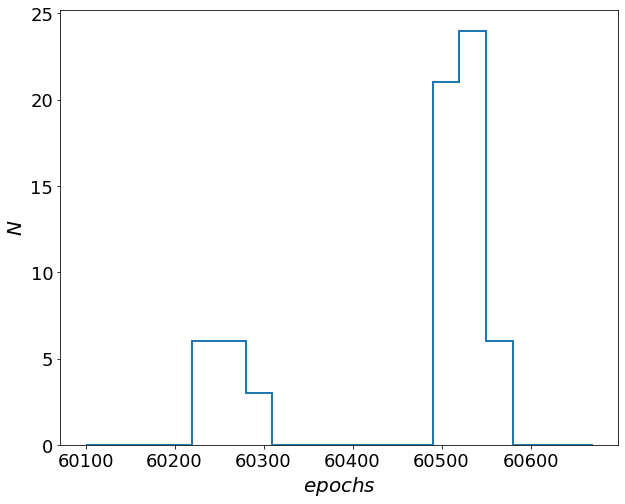

[9.768054652708994, -44.14753566298206]


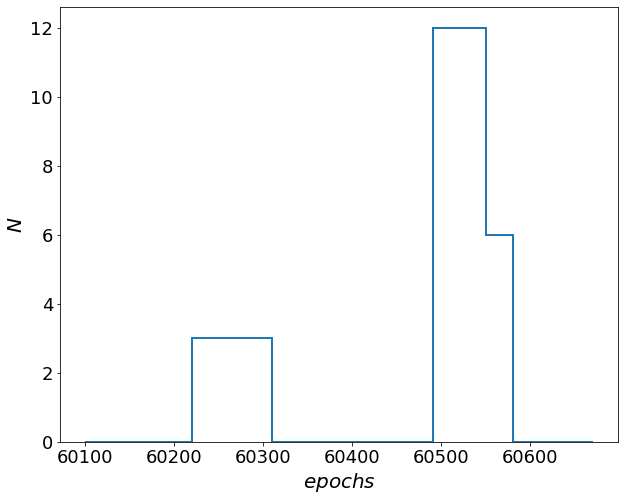

[9.10306028330164, -44.30164474806934]


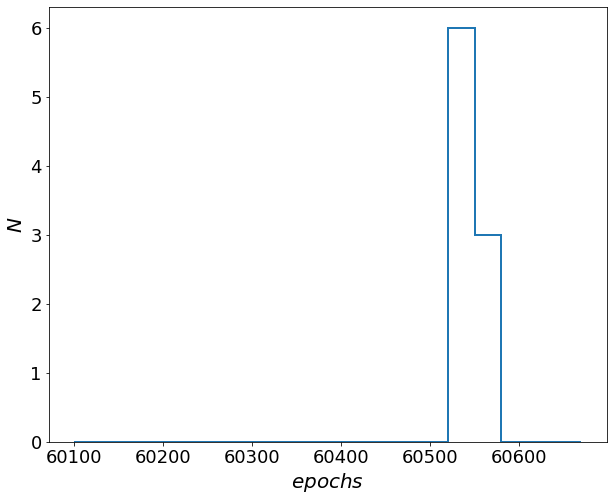

[9.616108391857182, -44.19110354964379]


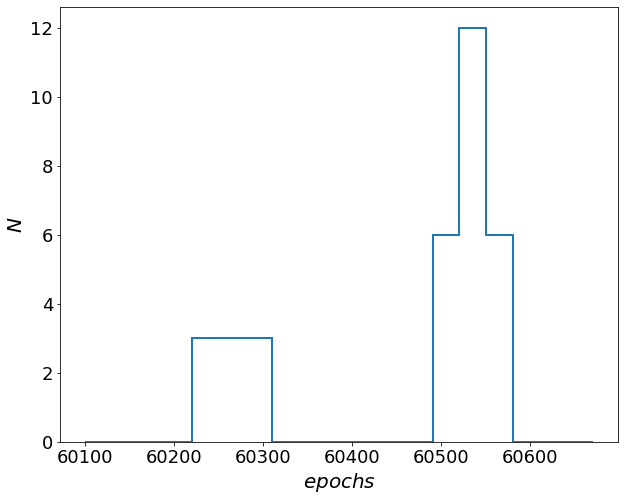

[63.6508688271131, -47.42258375601723]


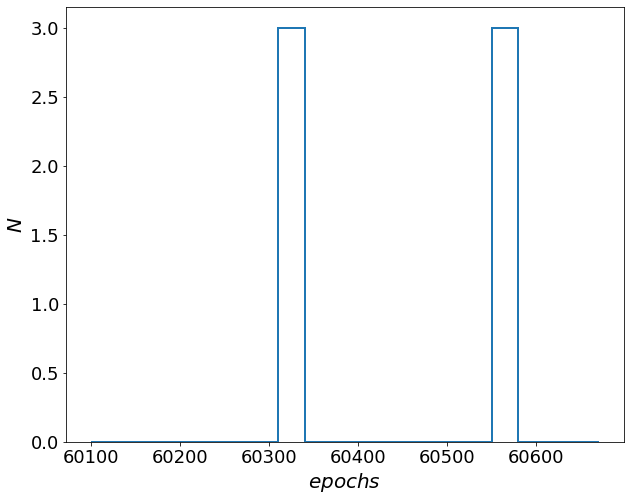

[63.67989908193194, -47.33933588905497]


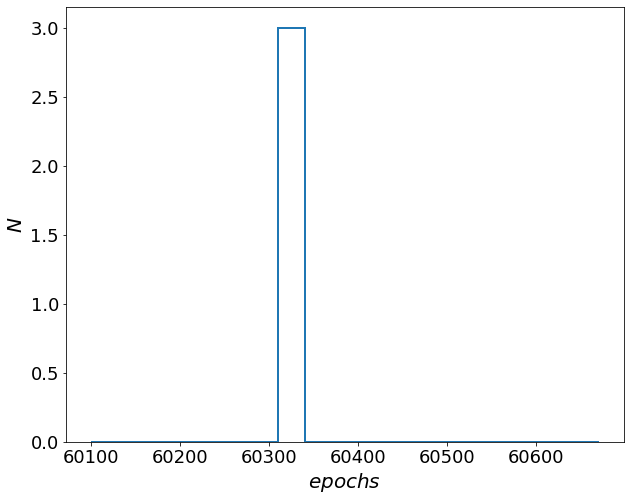

[62.680490783749384, -47.74081458326225]


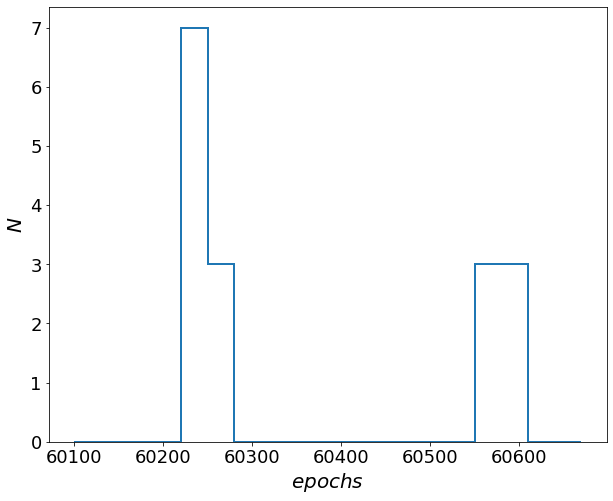

[63.088916787755146, -47.76841383804285]


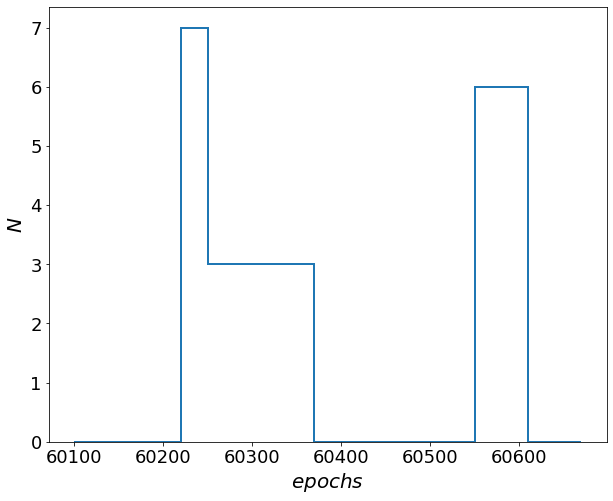

[63.312899317966675, -47.74081458326225]


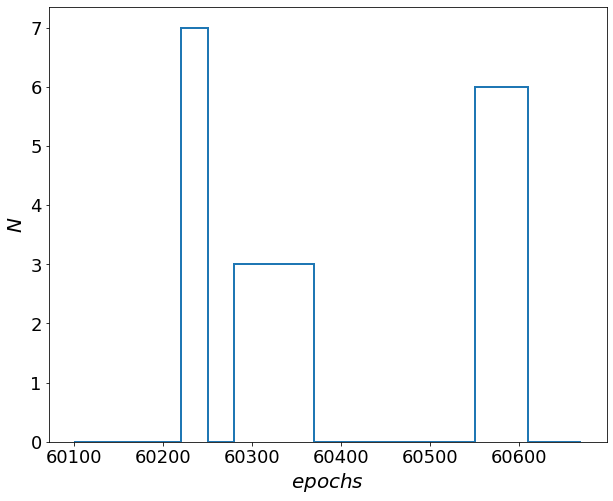

[63.67989908193194, -47.33933588905497]


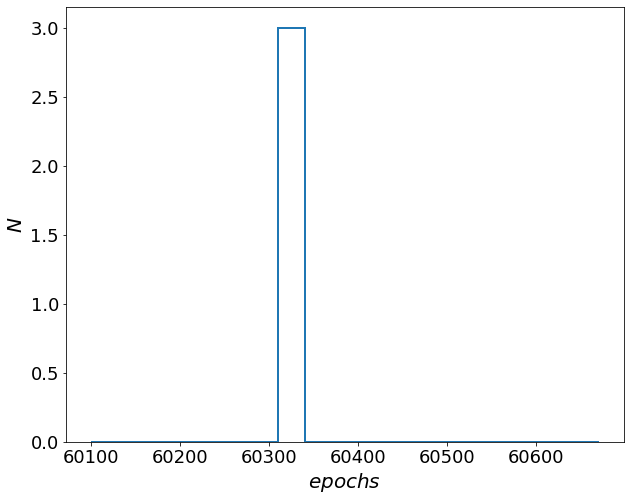

[59.331539694260044, -49.081688468030606]


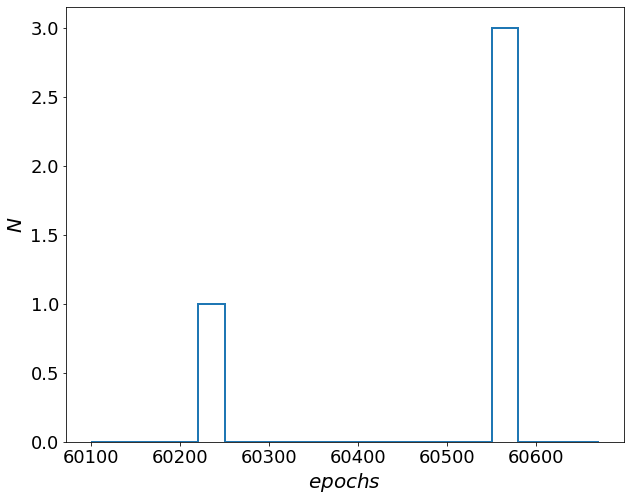

[62.680490783749384, -47.74081458326225]


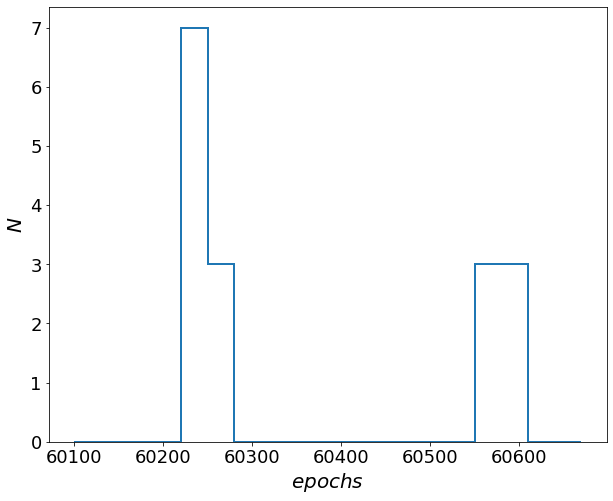

[63.088916787755146, -47.76841383804285]


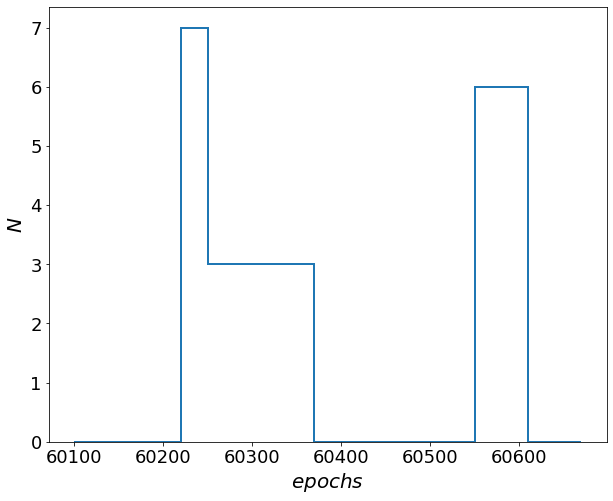

[63.088916787755146, -47.76841383804285]


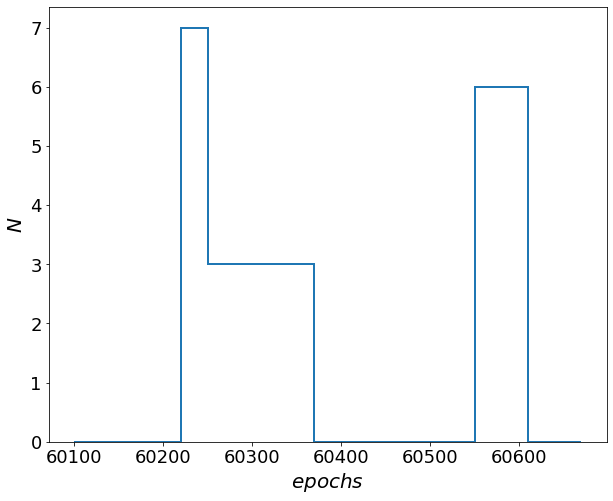

[63.542575138348475, -47.670648528921845]


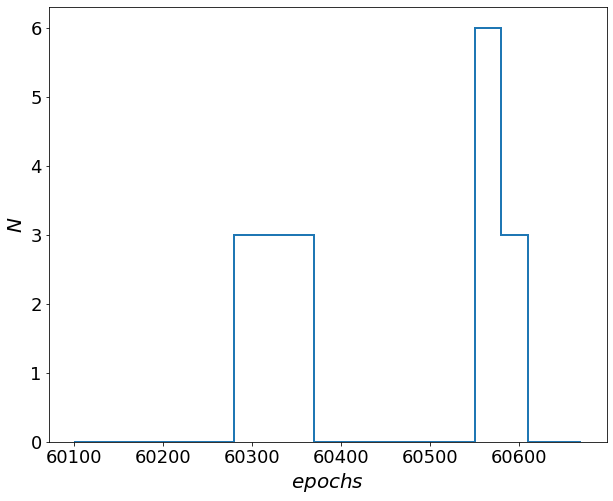

[58.70213280416565, -49.250049788814636]


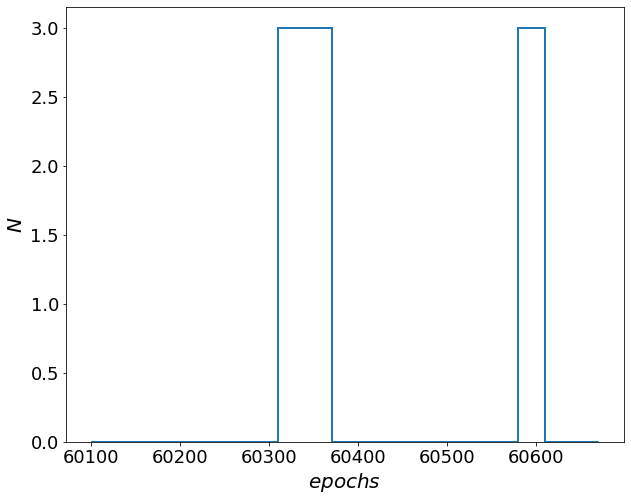

[59.256856762451385, -49.250049788814636]


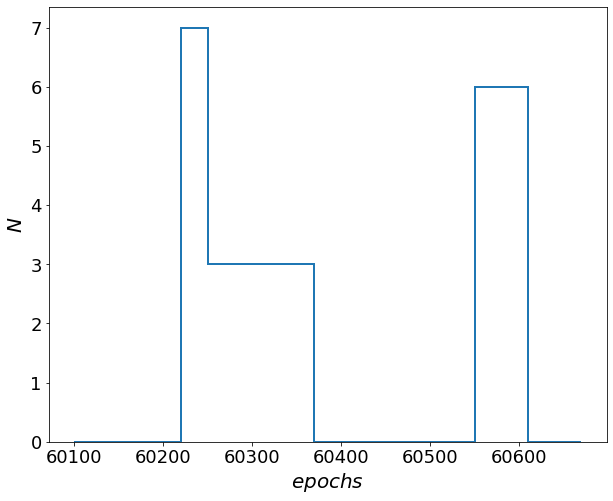

[59.25779345994895, -49.24531229436806]


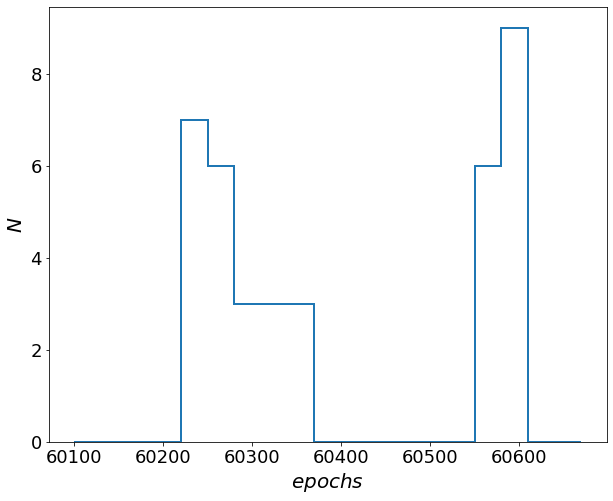

[63.088916787755146, -47.76841383804285]


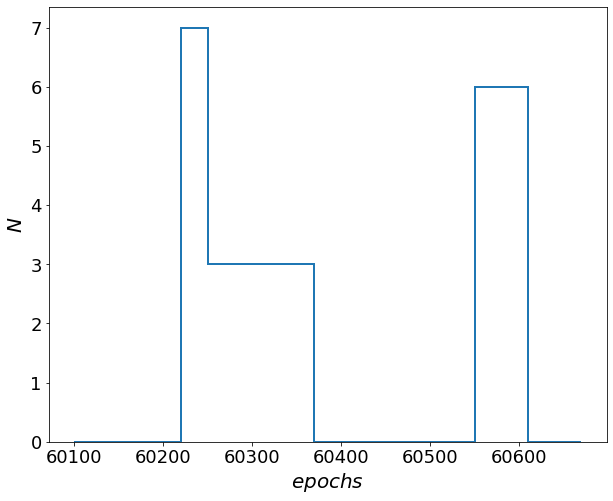

[63.088916787755146, -47.76841383804285]


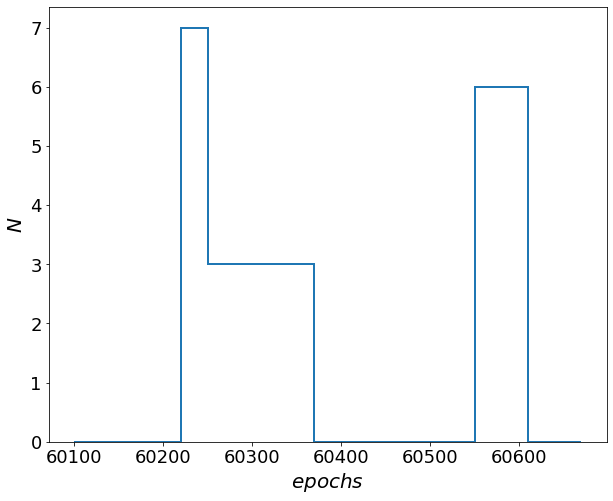

[63.088916787755146, -47.76841383804285]


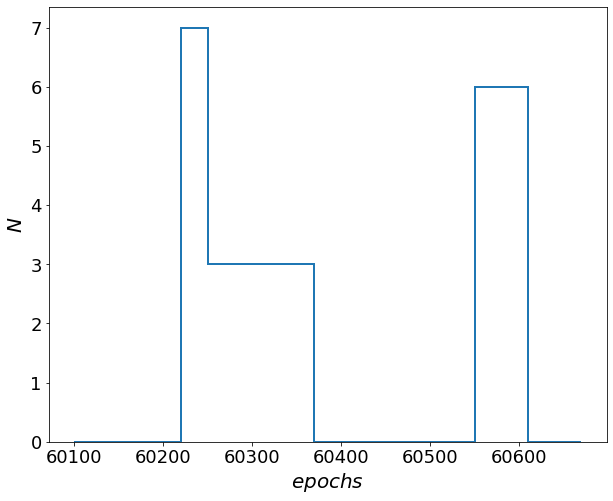

[58.70213280416565, -49.250049788814636]


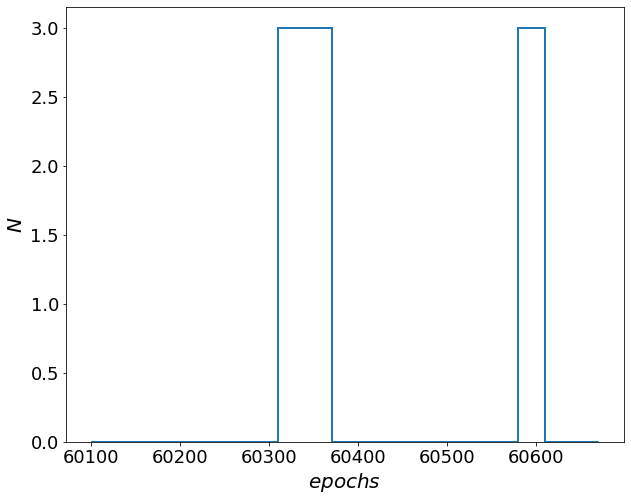

[59.256856762451385, -49.250049788814636]


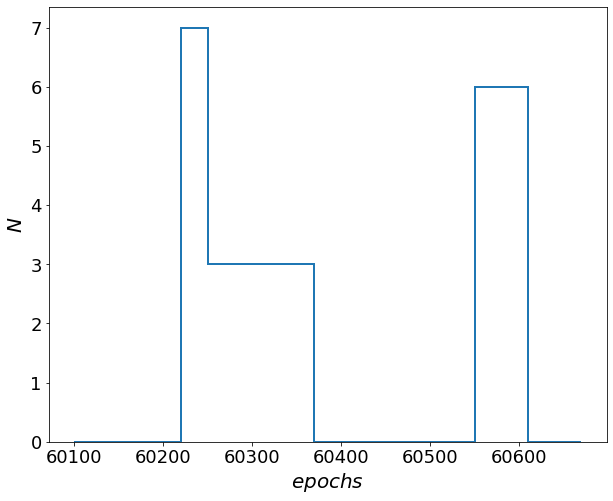

[59.256856762451385, -49.250049788814636]


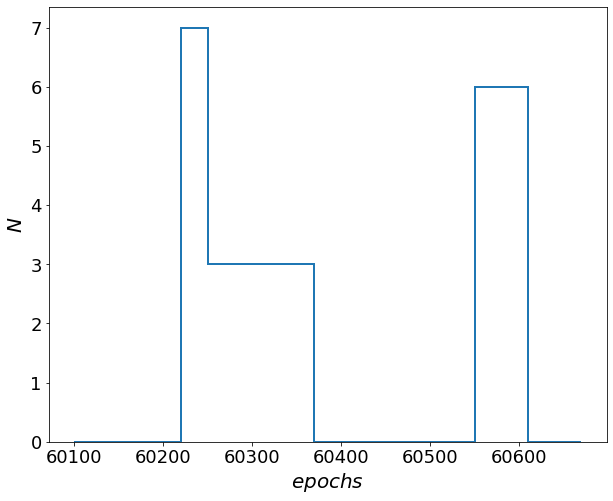

[59.331539694260044, -49.17804483694071]


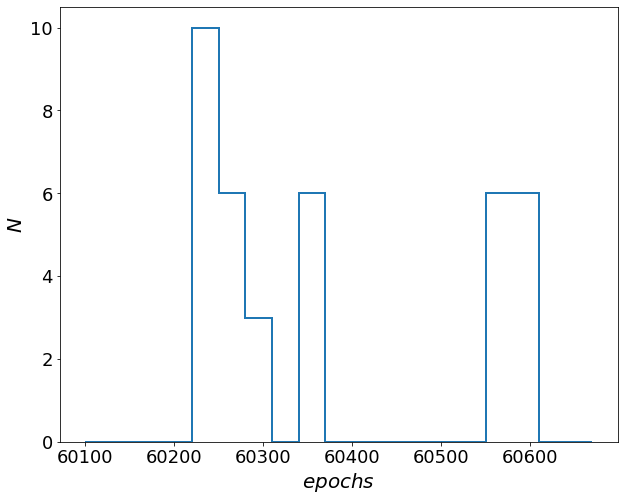

[63.088916787755146, -47.76841383804285]


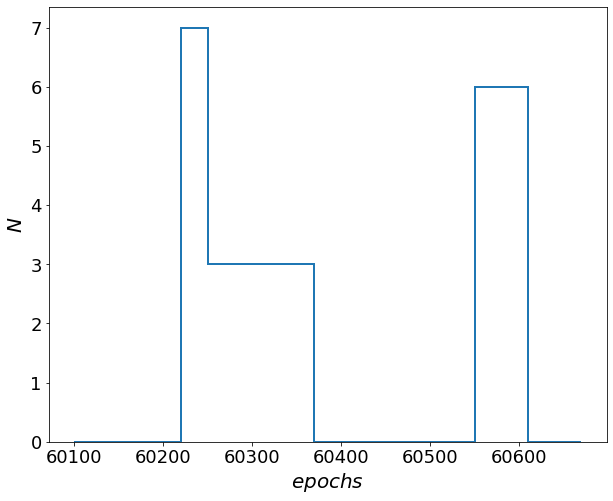

[63.312899317966675, -47.76841383804285]


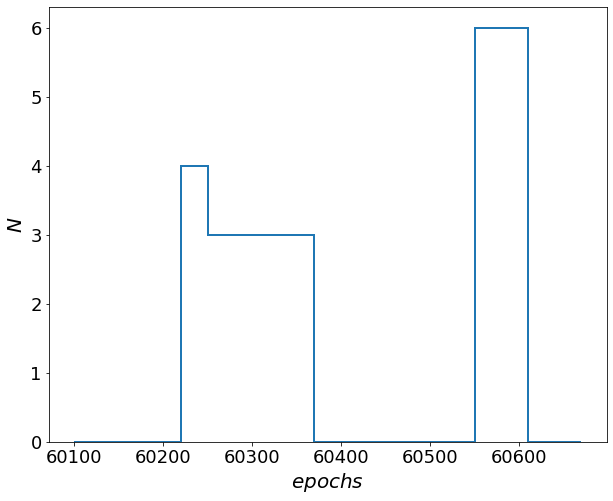

[59.256856762451385, -49.250049788814636]


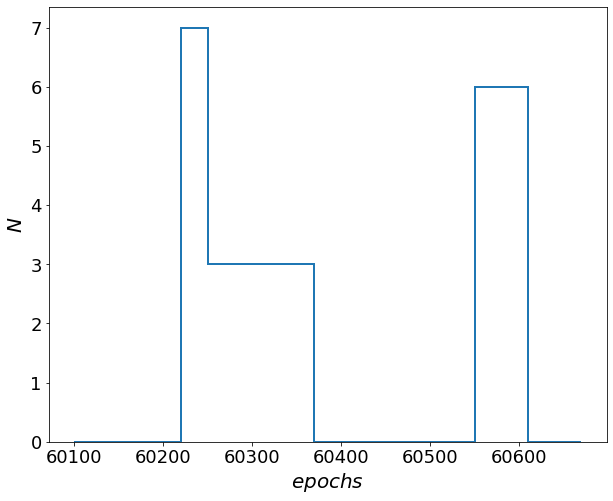

[59.256856762451385, -49.250049788814636]


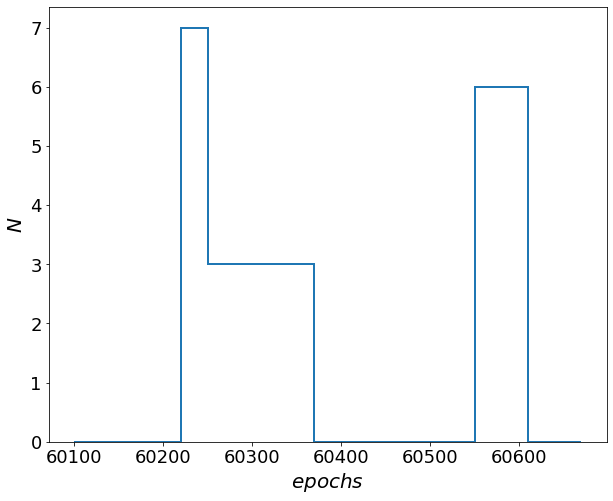

[59.256856762451385, -49.250049788814636]


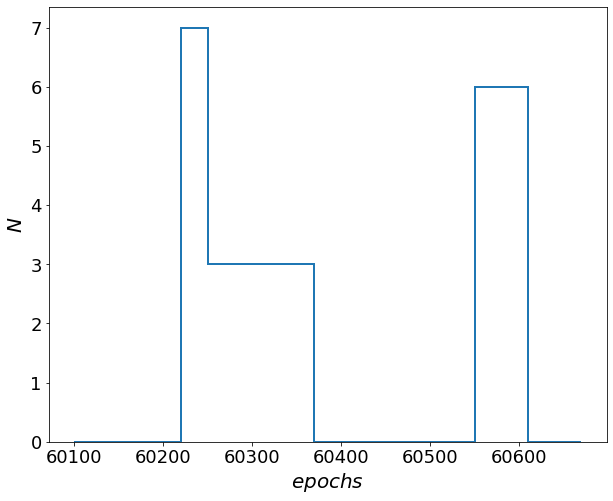

[62.55829021823439, -48.01666625325948]


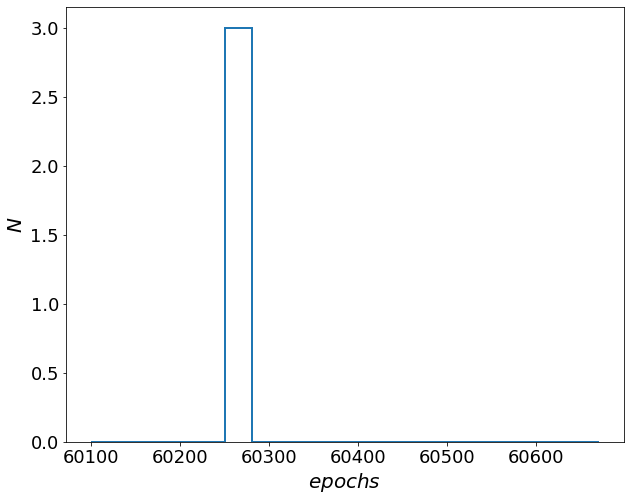

[58.74353742367839, -49.34091462826006]


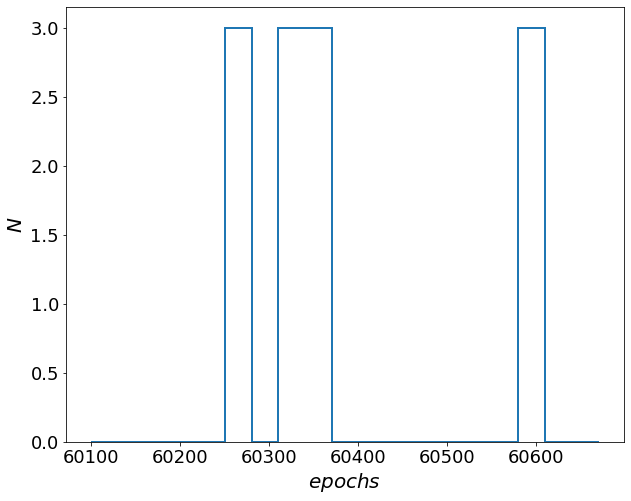

[59.20151374106399, -49.25844695053539]


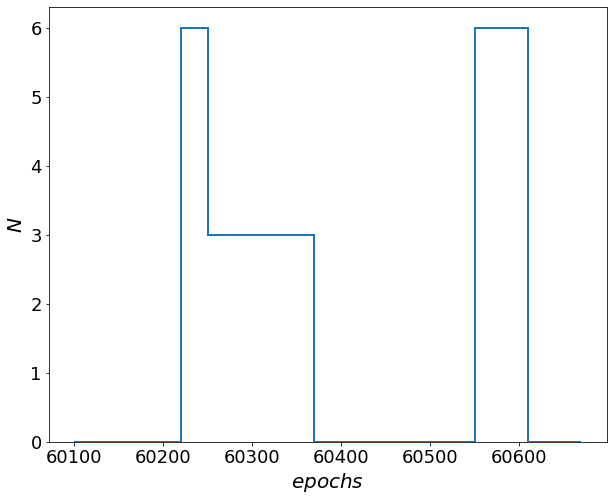

[59.256856762451385, -49.250049788814636]


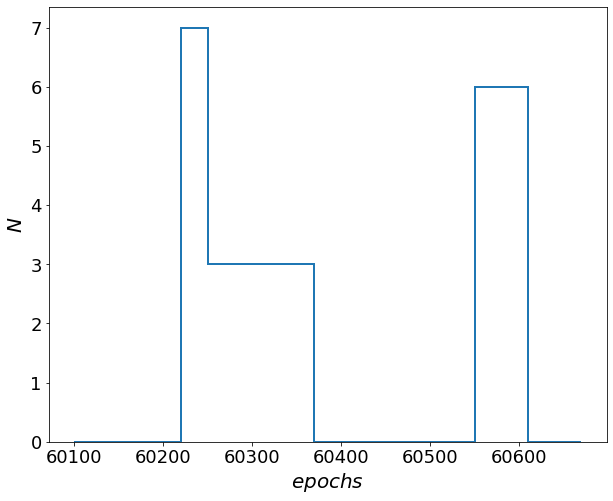

In [21]:
mjd = []
for k in df17['baseline_nexp1_v1.7_10yrs'].keys():
    N= k.split('_')[1]
    print('____________________')
    print('NSIDE ={}'.format(N))
    print('____________________')
    for i in range(np.size(df17['baseline_nexp1_v1.7_10yrs'][k]['observationStartMJD'])):
       # print([np.unique(df17['baseline_nexp1_v1.7_10yrs']['get_Col']['fieldRA'][i]), np.unique(df17['baseline_nexp1_v1.7_10yrs']['get_Col']['fieldDec'][i])])
        obs = {'observationStartMJD':df17['baseline_nexp1_v1.7_10yrs'][k]['observationStartMJD'][i],
               'night':df17['baseline_nexp1_v1.7_10yrs'][k]['night'][i], 
               'filter':df17['baseline_nexp1_v1.7_10yrs'][k]['filter'][i], 
               'idpix':radec2pix(16,np.radians(df17['baseline_nexp1_v1.7_10yrs'][k]['fieldRA'][i]),
                                 np.radians(df17['baseline_nexp1_v1.7_10yrs'][k]['fieldDec'][i]))}
        df = pd.DataFrame(obs)
        keygroup = ['filter', 'night','idpix']
        df.sort_values(by=keygroup, ascending=[
                     True, True,True], inplace=True)
        coadd_df = df.groupby(keygroup).agg({'observationStartMJD': ['mean']}).reset_index()

        coadd_df.columns = ['filter','night','idpix', 'observationStartMJD' ]



        coadd_df.sort_values(by=['filter', 'night','idpix'], ascending=[
                         True, True,True], inplace=True)
        idx = np.where((coadd_df['idpix']==1467))
        mjd.append(np.array(coadd_df['observationStartMJD'])[idx])

    
        plt.figure(figsize=(10,8))
        print([np.median(df17['baseline_nexp1_v1.7_10yrs'][k]['fieldRA'][i]),
               np.median(df17['baseline_nexp1_v1.7_10yrs'][k]['fieldDec'][i])])
        plt.hist(coadd_df['observationStartMJD'],bins=np.arange(60100,60700,30), histtype='step', align='mid', lw=2)
        plt.xlabel(r"$epochs$",fontsize= 20)
        plt.ylabel(r"$N$",fontsize= 20)
        plt.tick_params('both', labelsize=18)
        plt.show()

In [27]:
ra_,dec_= df17['baseline_nexp1_v1.7_10yrs']['getcol_8']['coo'][0]

In [29]:
df17['baseline_nexp1_v1.7_10yrs']['getcol_8']['coo'][0][1]

-4.956245128231688

In [56]:
ra_,dec_= np.array(ra_metric),np.array(dec_metric)

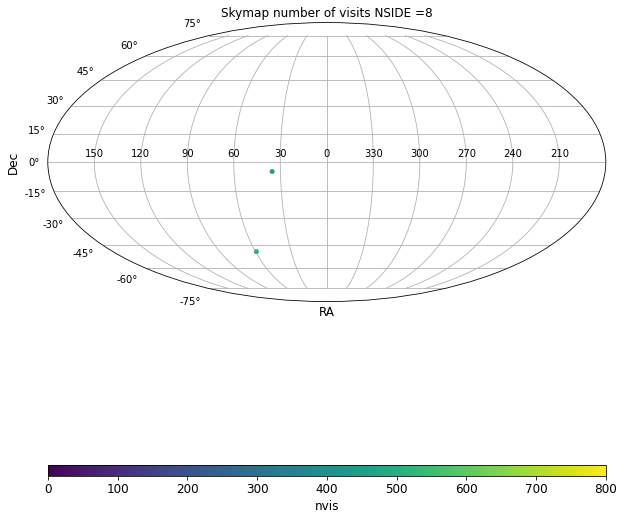

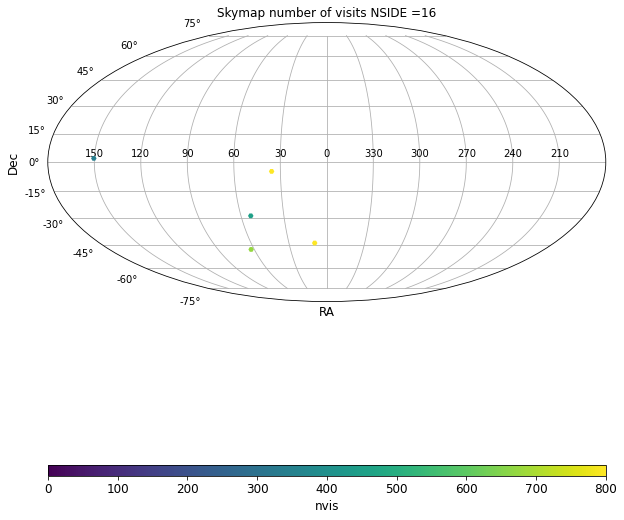

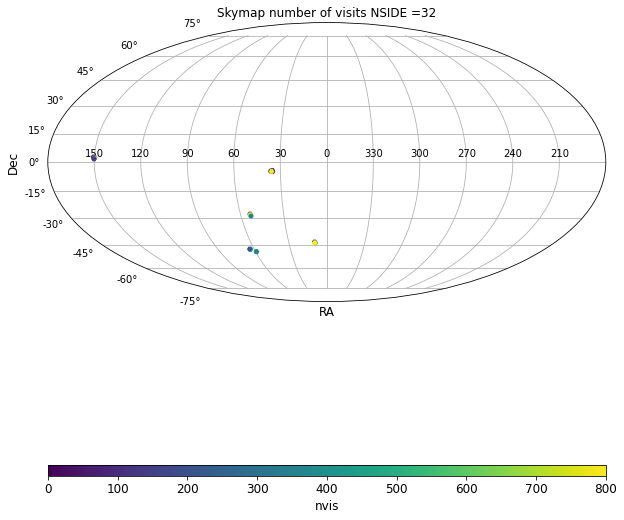

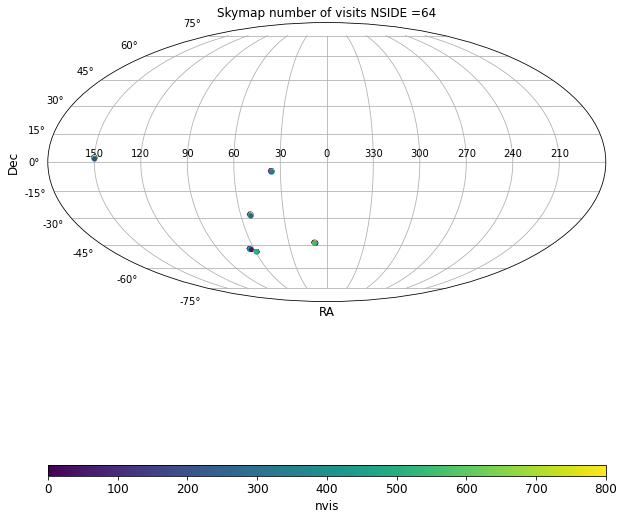

In [35]:
for k in df17['baseline_nexp1_v1.7_10yrs'].keys():
    N= k.split('_')[1]
    
    ra_,dec_=[],[]
    for i in range(np.size(df17['baseline_nexp1_v1.7_10yrs'][k]['coo'])):
       
        ra_.append(df17['baseline_nexp1_v1.7_10yrs'][k]['coo'][i][0])
        dec_.append(df17['baseline_nexp1_v1.7_10yrs'][k]['coo'][i][1])
    fig=plt.figure(figsize=(10,20))

    ax= fig.add_subplot(1,1,1, projection='mollweide')
    plt_mlw(ax,np.array(ra_),np.array(dec_),c=nvis[k],vmin=0,vmax=800,dicts={'marker':'H','cbartitle':'nvis','colormap':'viridis','title': 'Skymap number of visits NSIDE ={}'.format(N),'psize':30})
#plt.savefig('./Figure/skymap_fraction.pdf')